<a href="https://colab.research.google.com/github/hagabbar/OzGrav_demo/blob/master/OzGrav_VItamin_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
!git pull 

remote: Enumerating objects: 117, done.
remote: Counting objects: 100% (117/117), done.
remote: Compressing objects: 100% (114/114), done.
remote: Total 116 (delta 1), reused 116 (delta 1), pack-reused 0
Receiving objects: 100% (116/116), 1.10 GiB | 14.84 MiB/s, done.
Resolving deltas: 100% (1/1), completed with 1 local object.
From https://github.com/hagabbar/OzGrav_demo
   712392e..64d3e82  master     -> origin/master
Updating 712392e..64d3e82
Checking out files: 100% (111/111), done.
Fast-forward
 .../tset_tot-100000_split-1000/data_1000-100000.h5py | Bin 0 -> 12429040 bytes
 .../data_10000-100000.h5py                           | Bin 0 -> 12429040 bytes
 .../data_100000-100000.h5py                          | Bin 0 -> 12429040 bytes
 .../data_11000-100000.h5py                           | Bin 0 -> 12429040 bytes
 .../data_12000-100000.h5py                           | Bin 0 -> 12429040 bytes
 .../data_13000-100000.h5py                           | Bin 0 -> 12429040 bytes
 .../data_14000

# Set-up

In [2]:
!git clone https://github.com/hagabbar/OzGrav_demo.git

fatal: destination path 'OzGrav_demo' already exists and is not an empty directory.


In [3]:
%cd OzGrav_demo/
%ls

/content/OzGrav_demo
bilby_pe.py       OzGrav_VItamin_demo.ipynb  requirements.txt
LICENSE           plotsky.py                 test_sets/
Models/           plots.py                   training_sets_3det_9par_256Hz/
Neural_Networks/  README.md                  VICI_code_usage_example.py


In [13]:
pip install -r requirements.txt

     |████████████████████████████████| 102kB 2.3MB/s 
     |████████████████████████████████| 266kB 8.5MB/s 
     |████████████████████████████████| 6.3MB 13.4MB/s 
     |████████████████████████████████| 204kB 39.3MB/s 
     |████████████████████████████████| 4.4MB 40.9MB/s 
     |████████████████████████████████| 102kB 10.1MB/s 
     |████████████████████████████████| 1.5MB 43.4MB/s 
     |████████████████████████████████| 163kB 44.8MB/s 
     |████████████████████████████████| 440kB 41.6MB/s 
     |████████████████████████████████| 2.3MB 45.3MB/s 
     |████████████████████████████████| 2.1MB 42.3MB/s 
     |████████████████████████████████| 92kB 8.8MB/s 
     |████████████████████████████████| 829kB 39.9MB/s 
     |████████████████████████████████| 81kB 8.8MB/s 
     |████████████████████████████████| 2.7MB 40.1MB/s 
     |████████████████████████████████| 1.3MB 30.3MB/s 
     |████████████████████████████████| 2.8MB 42.8MB/s 
     |████████████████████████████████| 13.5MB 237kB/s

In [0]:
import numpy as np
from IPython.display import Image, display

Make sure to enable GPU in Edit -> Notebook setting -> Hardware accelerator

# Running VItamin on your own

In the Running VItamin section, you will be able to generate your own data and run your own neural network to produce GW posteriors. 

## Generate Bilby Posterior Test Samples

In this section I provide the code to generate your own bilby GW posteriors and their associated GW waveforms.

### Define bounds and default fixed values for source parameters and search

In [0]:
# Source parameter values to use if chosen to be fixed
fixed_vals = {'mass_1':50.0,
        'mass_2':50.0,
        'mc':None,
        'geocent_time':0.0,
        'phase':0.0,
        'ra':1.375,
        'dec':-1.2108,
        'psi':0.0,
        'theta_jn':0.0,
        'luminosity_distance':2000.0,
        'a_1':0.0,
        'a_2':0.0,
	'tilt_1':0.0,
	'tilt_2':0.0,
        'phi_12':0.0,
        'phi_jl':0.0,
        'det':['H1','L1','V1']}                                                 # feel free to edit this if more or less detectors wanted


# Prior bounds on source parameters
bounds = {'mass_1_min':35.0, 'mass_1_max':80.0,
        'mass_2_min':35.0, 'mass_2_max':80.0,
        'M_min':70.0, 'M_max':160.0,
        'geocent_time_min':0.15,'geocent_time_max':0.35,
        'phase_min':0.0, 'phase_max':2.0*np.pi,
        'ra_min':0.0, 'ra_max':2.0*np.pi,
        'dec_min':-0.5*np.pi, 'dec_max':0.5*np.pi,
        'psi_min':0.0, 'psi_max':2.0*np.pi,
        'theta_jn_min':0.0, 'theta_jn_max':np.pi,
        'a_1_min':0.0, 'a_1_max':0.0,
        'a_2_min':0.0, 'a_2_max':0.0,
        'tilt_1_min':0.0, 'tilt_1_max':0.0,
        'tilt_2_min':0.0, 'tilt_2_max':0.0,
        'phi_12_min':0.0, 'phi_12_max':0.0,
        'phi_jl_min':0.0, 'phi_jl_max':0.0,
        'luminosity_distance_min':1000.0, 'luminosity_distance_max':3000.0}

### Define run parameters

In [0]:
##########################
# Main tunable variables
##########################
ndata = 256                                                                     # sampling frequency
rand_pars = ['mass_1','mass_2','luminosity_distance','geocent_time','phase',
                 'theta_jn','psi','ra','dec']                                   # parameters to randomize (those not listed here are fixed otherwise)
inf_pars=['luminosity_distance','geocent_time','ra','dec'],                     # parameters to infer
batch_size = 64                                                                 # Number training samples shown to neural network per iteration
weight_init = 'xavier',                                                         #[xavier,VarianceScaling,Orthogonal] # Network model weight initialization    
n_modes=7,                                                                      # number of modes in Gaussian mixture model (ideal 7, but may go higher/lower)
initial_training_rate=1e-4,                                                     # initial training rate for ADAM optimiser inference model (inverse reconstruction)
batch_norm=True,                                                                # if true, do batch normalization in all layers of neural network

# FYI, each item in lists below correspond to each layer in networks (i.e. first item first layer)
# pool size and pool stride should be same number in each layer
n_filters_r1 = [33, 33],                                                    # number of convolutional filters to use in r1 network (must be divisible by 3)
n_filters_r2 = [33, 33],                                                    # number of convolutional filters to use in r2 network (must be divisible by 3)
n_filters_q = [33, 33],                                                     # number of convolutional filters to use in q network  (must be divisible by 3)
filter_size_r1 = [3,3],                                                       # size of convolutional fitlers in r1 network
filter_size_r2 = [3,3],                                                       # size of convolutional filters in r2 network
filter_size_q = [3,3],                                                        # size of convolutional filters in q network
drate = 0.5,                                                                    # dropout rate to use in fully-connected layers
maxpool_r1 = [1,2],                                                           # size of maxpooling to use in r1 network
conv_strides_r1 = [1,1],                                                      # size of convolutional stride to use in r1 network
pool_strides_r1 = [1,2],                                                      # size of max pool stride to use in r1 network
maxpool_r2 = [1,2],                                                           # size of max pooling to use in r2 network
conv_strides_r2 = [1,1],                                                      # size of convolutional stride in r2 network
pool_strides_r2 = [1,2],                                                      # size of max pool stride in r2 network
maxpool_q = [1,2],                                                            # size of max pooling to use in q network
conv_strides_q = [1,1],                                                       # size of convolutional stride to use in q network
pool_strides_q = [1,2],                                                       # size of max pool stride to use in q network
n_fc = 512                                                                      # Number of neurons in fully-connected layers
z_dimension=50,                                                                  # number of latent space dimensions of model 
n_weights_r1 = [n_fc,n_fc],                                                     # number fully-connected layers of encoders and decoders in the r1 model (inverse reconstruction)
n_weights_r2 = [n_fc,n_fc],                                                     # number fully-connected layers of encoders and decoders in the r2 model (inverse reconstruction)
n_weights_q = [n_fc,n_fc],                                                      # number fully-connected layers of encoders and decoders q model
##########################
# Main tunable variables
##########################

#############################
# optional tunable variables
#############################
run_label = 'ozgrav-demo_%ddet_%dpar_%dHz_run1' % (len(fixed_vals['det']),len(rand_pars),ndata) # label of run
bilby_results_label = 'ozgrav-demo'                                             # label given to bilby results directory
r = 2                                                                           # number (to the power of 2) of test samples to use for testing. r = 2 means you want to use 2^2 (i.e 4) test samples
pe_test_num = 256                                                               # total number of test samples available to use in directory
tot_dataset_size = int(1e5)                                                     # total number of training samples available to use
tset_split = int(1e3)                                                           # number of training samples in each training data file
save_interval = int(5e4)                                                        # number of iterations to save model and plot validation results corner plots
ref_geocent_time=1126259642.5                                                   # reference gps time (not advised to change this)
load_chunk_size = 1e5                                                           # Number of training samples to load in at a time.
samplers=['vitamin','dynesty'],                                                 # Bayesian samplers to use when comparing ML results (vitamin is ML approach) dynesty,ptemcee,cpnest,emcee

# Directory variables
plot_dir="results/%s" % run_label,  # output directory to save results plots
train_set_dir='training_sets_%ddet_%dpar_%dHz/tset_tot-%d_split-%d' % (len(fixed_vals['det']),len(rand_pars),ndata,tot_dataset_size,tset_split), # location of training set
test_set_dir='test_sets/%s/four_parameter_case/test_waveforms' % bilby_results_label,                                                            # location of test set directory waveforms
pe_dir='test_sets/%s/four_parameter_case/test' % bilby_results_label,                                                                            # location of test set directory Bayesian PE samples
#############################
# optional tunable variables
#############################

In [0]:

# Function for getting list of parameters that need to be fed into the models
def get_params():

    # Define dictionary to store values used in rest of code 
    params = dict(
        make_corner_plots = True,                                               # if True, make corner plots
        make_kl_plot = True,                                                    # If True, go through kl plotting function
        make_pp_plot = True,                                                    # If True, go through pp plotting function
        make_loss_plot = False,                                                 # If True, generate loss plot from previous plot data
        Make_sky_plot=False,                                                    # If True, generate sky plots on corner plots
        hyperparam_optim = False,                                               # optimize hyperparameters for model during training using gaussian process minimization
        resume_training=False,                                                  # if True, resume training of a model from saved checkpoint
        load_by_chunks = True,                                                  # if True, load training samples by a predefined chunk size rather than all at once
        ramp = True,                                                            # if true, apply linear ramp to KL loss
        print_values=True,                                                      # optionally print loss values every report interval
        by_channel = True,                                                      # if True, do convolutions as seperate 1-D channels, if False, stack training samples as 2-D images (n_detectors,(duration*sampling_frequency))
        load_plot_data=False,                                                   # Plotting data which has already been generated
        doPE = True,                                                            # if True then do bilby PE when generating new testing samples (not advised to change this)
        gpu_num=0,                                                              # gpu number run is running on
        ndata = ndata,                                                          
        run_label=run_label,                                                    
        bilby_results_label=bilby_results_label,                                
        tot_dataset_size = tot_dataset_size,                                    
        tset_split = tset_split,                                                
        plot_dir=plot_dir,

        # Gaussian Process automated hyperparameter tunning variables
        hyperparam_optim_stop = int(1.5e6),                                     # stopping iteration of hyperparameter optimizer per call (ideally 1.5 million) 
        hyperparam_n_call = 30,                                                 # number of hyperparameter optimization calls (ideally 30)
        load_chunk_size = load_chunk_size,                                      
        load_iteration = int((load_chunk_size * 25)/batch_size),                # How often to load another chunk of training samples
        weight_init = weight_init[0],                                           
        n_samples = 1000,                                                       # number of posterior samples to save per reconstruction upon inference (default 3000) 
        num_iterations=int(1e7)+1,                                              # total number of iterations before ending training of model
        initial_training_rate=initial_training_rate[0],                         
        batch_size=batch_size,                                                  
        batch_norm=batch_norm,                                                  
        report_interval=500,                                                    # interval at which to save objective function values and optionally print info during training
        n_modes=n_modes[0],                                                     

        # FYI, each item in lists below correspond to each layer in networks (i.e. first item first layer)
        # pool size and pool stride should be same number in each layer
        n_filters_r1 = n_filters_r1[0],                                         
        n_filters_r2 = n_filters_r2[0],                                         
        n_filters_q = n_filters_q[0],                                           
        filter_size_r1 = filter_size_r1[0],                                     
        filter_size_r2 = filter_size_r2[0],                                     
        filter_size_q = filter_size_q[0],                                       
        drate = drate[0],                                                       
        maxpool_r1 = maxpool_r1[0],                                             
        conv_strides_r1 = conv_strides_r1[0],                                   
        pool_strides_r1 = pool_strides_r1[0],                                   
        maxpool_r2 = maxpool_r2[0],                                             
        conv_strides_r2 = conv_strides_r2[0],                                   
        pool_strides_r2 = pool_strides_r2[0],                                   
        maxpool_q = maxpool_q[0],                                               
        conv_strides_q = conv_strides_q[0],                                     
        pool_strides_q = pool_strides_q[0],                                     
        ramp_start = 1e4,                                                       # starting iteration of KL divergence ramp (if using)
        ramp_end = 1e5,                                                         # ending iteration of KL divergence ramp (if using)
        save_interval=save_interval,                                            
        plot_interval=save_interval,                                            
        z_dimension=z_dimension[0],                                              
        n_weights_r1 = n_weights_r1[0],                                         
        n_weights_r2 = n_weights_r2[0],                                         
        n_weights_q = n_weights_q[0],                                           
        duration = 1.0,                                                         # length of training/validation/test sample time series in seconds (haven't tried using at any other value than 1s)
        r = r,                                                                  
        rand_pars=rand_pars,                                                    
        corner_parnames = ['m_{1}\,(\mathrm{M}_{\odot})','m_{2}\,(\mathrm{M}_{\odot})','d_{\mathrm{L}}\,(\mathrm{Mpc})','t_{0}\,(\mathrm{seconds})','{\phi}','\Theta_{jn}\,(\mathrm{rad})','{\psi}',r'{\alpha}\,(\mathrm{rad})','{\delta}\,(\mathrm{rad})'], # latex source parameter labels for plotting
        cornercorner_parnames = ['$m_{1}\,(\mathrm{M}_{\odot})$','$m_{2}\,(\mathrm{M}_{\odot})$','$d_{\mathrm{L}}\,(\mathrm{Mpc})$','$t_{0}\,(\mathrm{seconds})$','${\phi}$','$\Theta_{jn}\,(\mathrm{rad})$','${\psi}$',r'${\alpha}\,(\mathrm{rad})$','${\delta}\,(\mathrm{rad})$'], # latex source parameter labels for plotting
        ref_geocent_time=ref_geocent_time,                                      
        training_data_seed=43,                                                  # tensorflow training random seed number
        testing_data_seed=44,                                                   # tensorflow testing random seed number
        wrap_pars=['phase','psi','ra'],                                         # Parameters to apply Von Mises wrapping on (not advised to change) 
        inf_pars=inf_pars,                                                      
        train_set_dir=train_set_dir,
        test_set_dir=test_set_dir,
        pe_dir=pe_dir,
        KL_cycles = 1,                                                          # number of cycles to repeat for the KL approximation
        samplers=samplers,                                                      
    )
    return params


# Save training/test parameters of run
params=get_params()
params['plot_dir']=params['plot_dir'][0]
params['train_set_dir']=params['train_set_dir'][0]
params['test_set_dir']=params['test_set_dir'][0]
params['pe_dir']=params['pe_dir'][0]
params['inf_pars']=params['inf_pars'][0]
params['samplers']=params['samplers'][0]
f = open("params_%s.txt" % params['run_label'],"w")
f.write( str(params) )
f.close()
f = open("params_%s_bounds.txt" % params['run_label'],"w")
f.write( str(bounds) )
f.close()
f = open("params_%s_fixed_vals.txt" % params['run_label'],"w")
f.write( str(fixed_vals) )
f.close()

### Generate Requested number of testing samples

Feel free to use the below command in your own time to generate more testing data. 

In the paper, we used a total of ~256 test samples. It is recommmened that if you are going to run this many test samples, that you split the test runs over condor.

In the notebook, I have provided 4 test cases using the dynesty sampler with 100 live points

In [17]:
!python VICI_code_usage_example.py --help

2020-06-14 15:29:01.092511: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer.so.6'; dlerror: libnvinfer.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2020-06-14 15:29:01.092704: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer_plugin.so.6'; dlerror: libnvinfer_plugin.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2020-06-14 15:29:01.092744: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:30] Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
15:29 bilby INFO    : Running bilby version: 0.5.5:
/usr/local/lib/python3.6/dist-packages/bilby/core/utils.py:903: MatplotlibDeprecationWarning: The 'warn' parameter of use() is deprecated since Matplotlib 3.

In [0]:
!python VICI_code_usage_example.py --gen_test True --params_file params_ozgrav-demo_3det_9par_256Hz_run1.txt --params_file_bounds params_ozgrav-demo_3det_9par_256Hz_run1_bounds.txt --params_file_fixed_vals params_ozgrav-demo_3det_9par_256Hz_run1_fixed_vals.txt 

## Generate Traning Samples

Demo default parameters are set to generate ~10,000 training samples, though for best results greater than 1 million samples is recommened (ideally 10 million).

In [0]:
!python VICI_code_usage_example.py --gen_train True --params_file params_ozgrav-demo_3det_9par_256Hz_run1.txt --params_file_bounds params_ozgrav-demo_3det_9par_256Hz_run1_bounds.txt --params_file_fixed_vals params_ozgrav-demo_3det_9par_256Hz_run1_fixed_vals.txt 

## Train Model

Training utilizes the K80 GPU available to use on the google colab tutorial for free. In the paper we use the NVIDIA DGX1 machine GPUs (just one) at the detector sites. Large convolutional models can take up to 8 - 16 Gb of GPU memory, so it is recommended to use as high end of a GPU as is available to you.

Corner plots are generated every 50,000 iterations in the results directory.

### Train

In [38]:
!python VICI_code_usage_example.py --train True --params_file params_ozgrav-demo_3det_9par_256Hz_run1.txt --params_file_bounds params_ozgrav-demo_3det_9par_256Hz_run1_bounds.txt --params_file_fixed_vals params_ozgrav-demo_3det_9par_256Hz_run1_fixed_vals.txt 

2020-06-14 15:57:27.704908: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer.so.6'; dlerror: libnvinfer.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2020-06-14 15:57:27.705032: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer_plugin.so.6'; dlerror: libnvinfer_plugin.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2020-06-14 15:57:27.705056: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:30] Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
15:57 bilby INFO    : Running bilby version: 0.5.5:
/usr/local/lib/python3.6/dist-packages/bilby/core/utils.py:903: MatplotlibDeprecationWarning: The 'warn' parameter of use() is deprecated since Matplotlib 3.

### Show progress of training run in plots

Cost function:

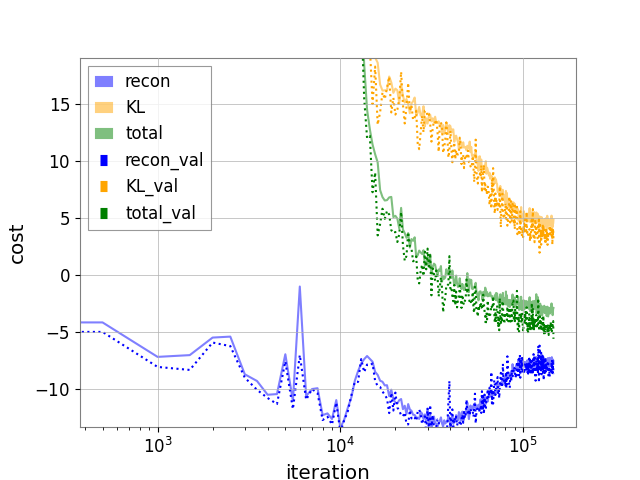

In [40]:
Image(filename='%s/latest_%s/cost_zoom_%s.png' % (params['plot_dir'],params['run_label'],params['run_label'])) 

Current Training results:

Red is VItamin, Blue is Dynesty

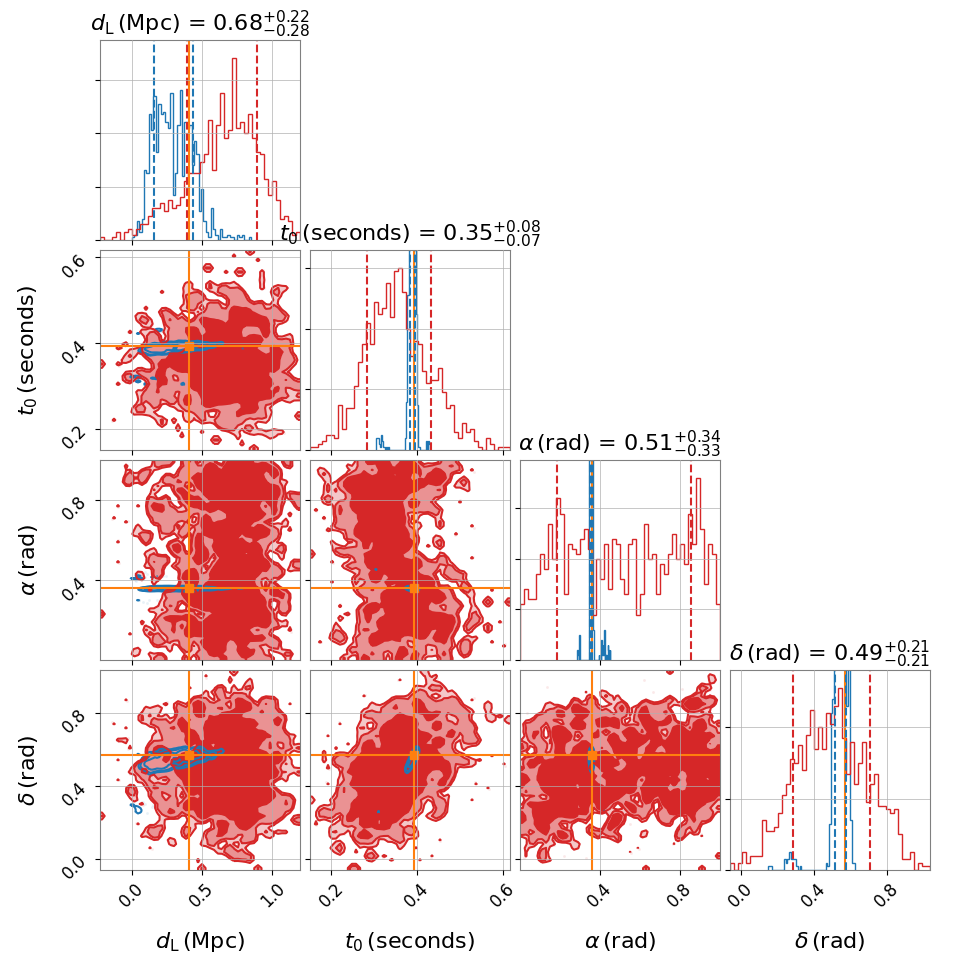

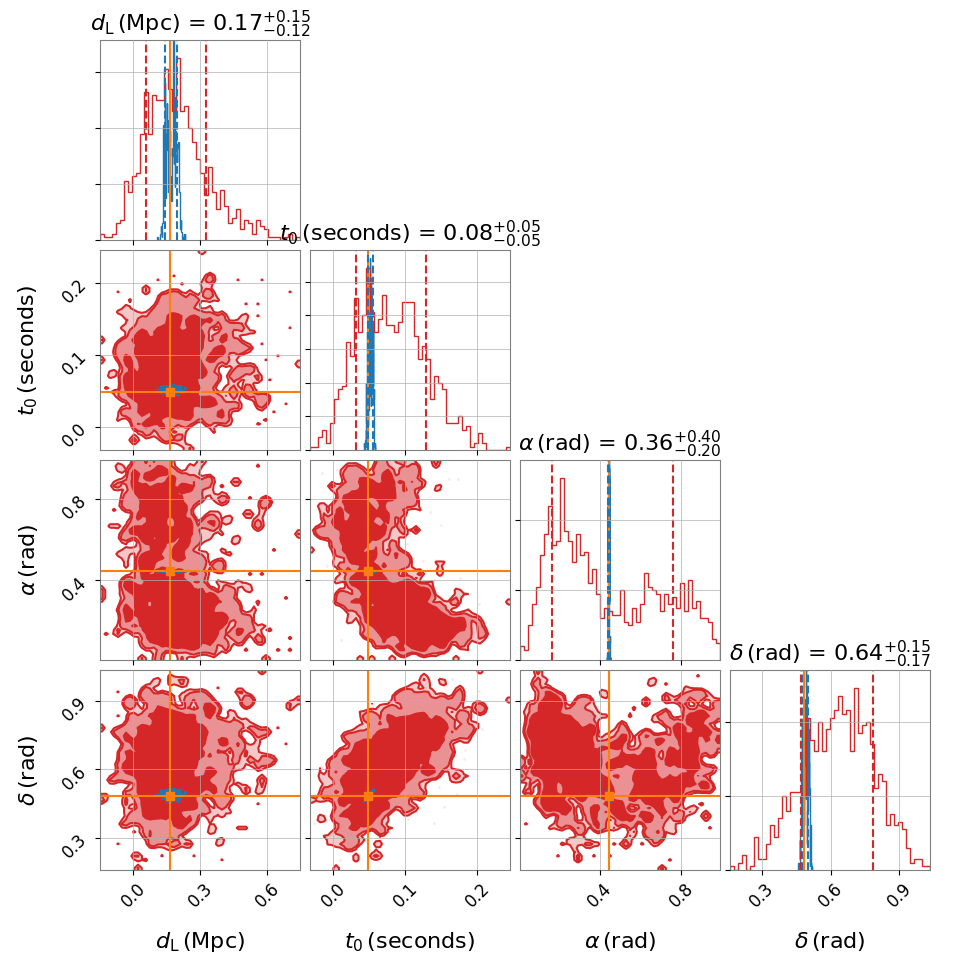

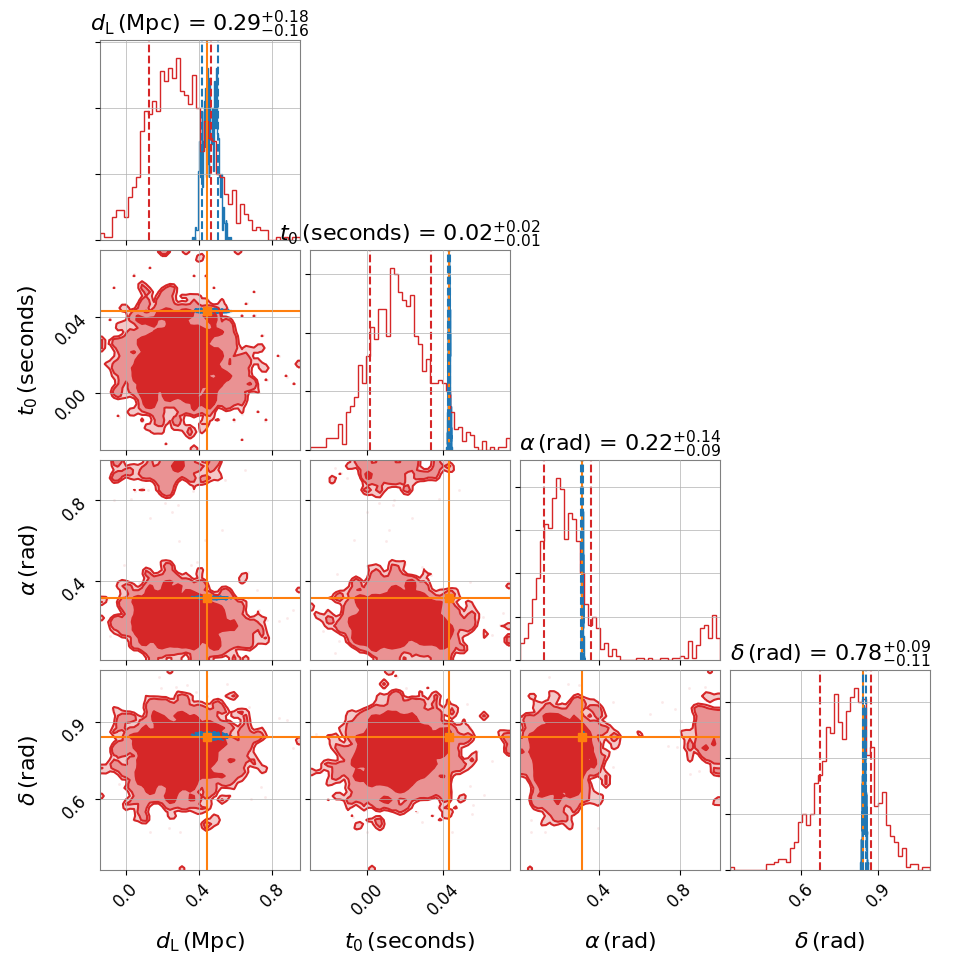

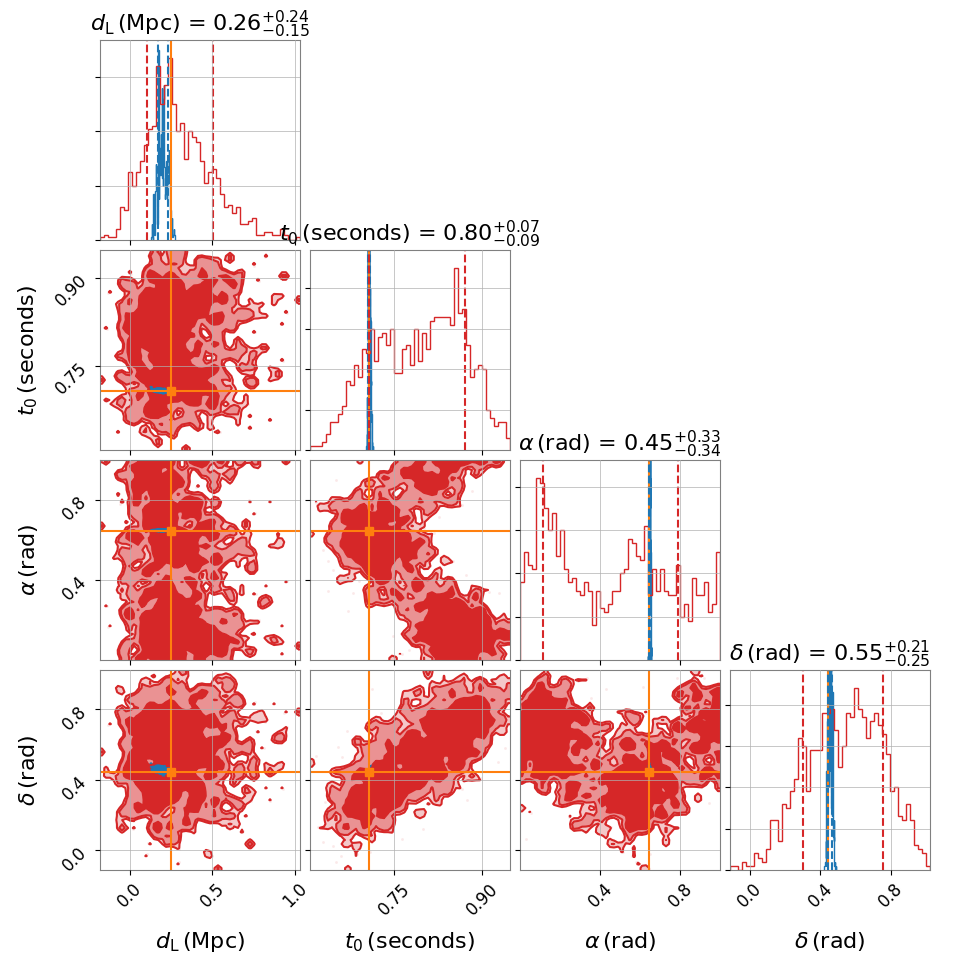

In [33]:
for i in range(params['r']**2):
    display(Image(filename='%s/latest_%s/corner_plot_%s_%d.png' % (params['plot_dir'],params['run_label'],params['run_label'],i))) 

To resume training, just set `resume_training` option in command line to True.







In [32]:
!python VICI_code_usage_example.py --resume_training True --params_file params_ozgrav-demo_3det_9par_256Hz_run1.txt --params_file_bounds params_ozgrav-demo_3det_9par_256Hz_run1_bounds.txt --params_file_fixed_vals params_ozgrav-demo_3det_9par_256Hz_run1_fixed_vals.txt 

2020-06-14 15:49:47.936923: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer.so.6'; dlerror: libnvinfer.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2020-06-14 15:49:47.937119: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer_plugin.so.6'; dlerror: libnvinfer_plugin.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2020-06-14 15:49:47.937144: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:30] Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
15:49 bilby INFO    : Running bilby version: 0.5.5:
/usr/local/lib/python3.6/dist-packages/bilby/core/utils.py:903: MatplotlibDeprecationWarning: The 'warn' parameter of use() is deprecated since Matplotlib 3.

## Compare Bilby vs. VItamin

This will produce three sets of plots. Corner plots comparing VItamin samples with all other requested Bayesian samples. KL divergence plots showing the KL divergence between VItamin and Bayesian samplers (ideally we should see that all distributions are similar). P-P plots which show how generally consistent with the truth each sampler is (ideally all samplers line up along the diagonal). Plots are stored in the results folder.

In this case, we will be loading in a pre-trained network. (~10 hrs training)

In [0]:
!python VICI_code_usage_example.py --test True --params_file params_ozgrav-demo_3det_9par_256Hz_run1.txt --params_file_bounds params_ozgrav-demo_3det_9par_256Hz_run1_bounds.txt --params_file_fixed_vals params_ozgrav-demo_3det_9par_256Hz_run1_fixed_vals.txt 

2020-06-14 13:45:07.601663: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer.so.6'; dlerror: libnvinfer.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2020-06-14 13:45:07.601802: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer_plugin.so.6'; dlerror: libnvinfer_plugin.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2020-06-14 13:45:07.601827: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:30] Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
13:45 bilby INFO    : Running bilby version: 0.5.5:
/usr/local/lib/python3.6/dist-packages/bilby/core/utils.py:903: MatplotlibDeprecationWarning: The 'warn' parameter of use() is deprecated since Matplotlib 3.

### Show plots

Corner plots:

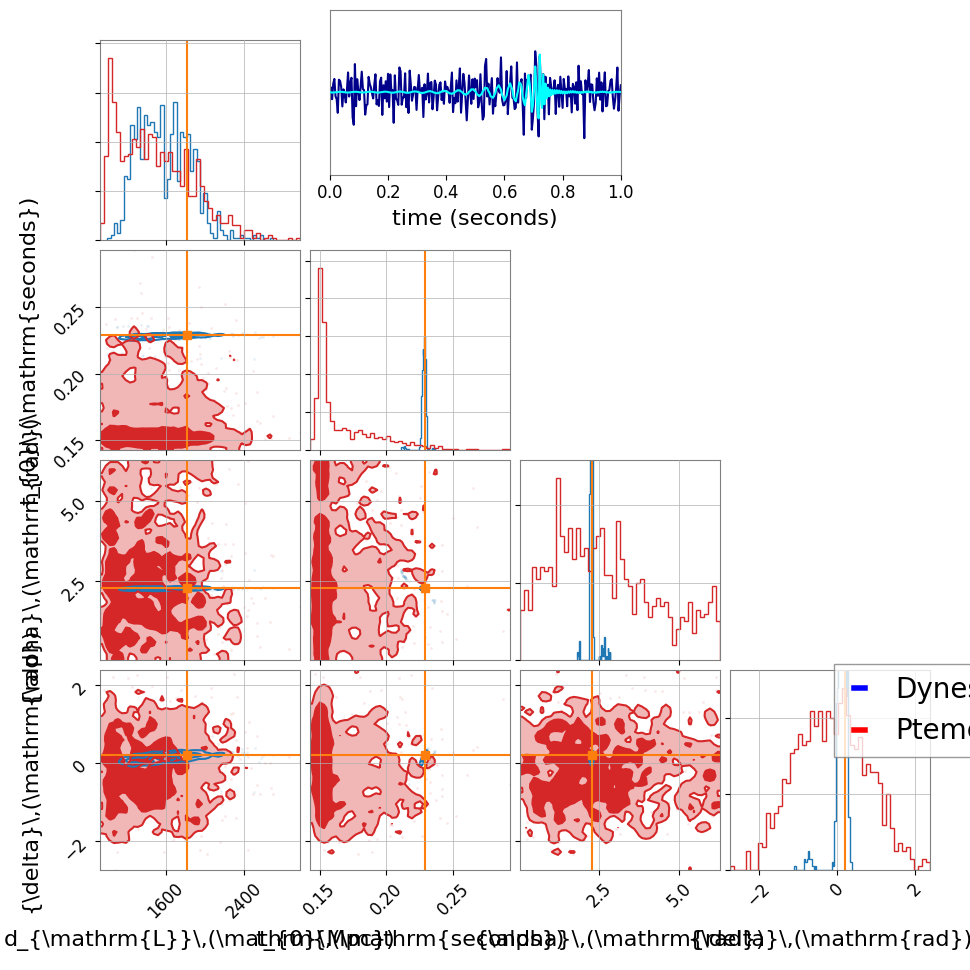

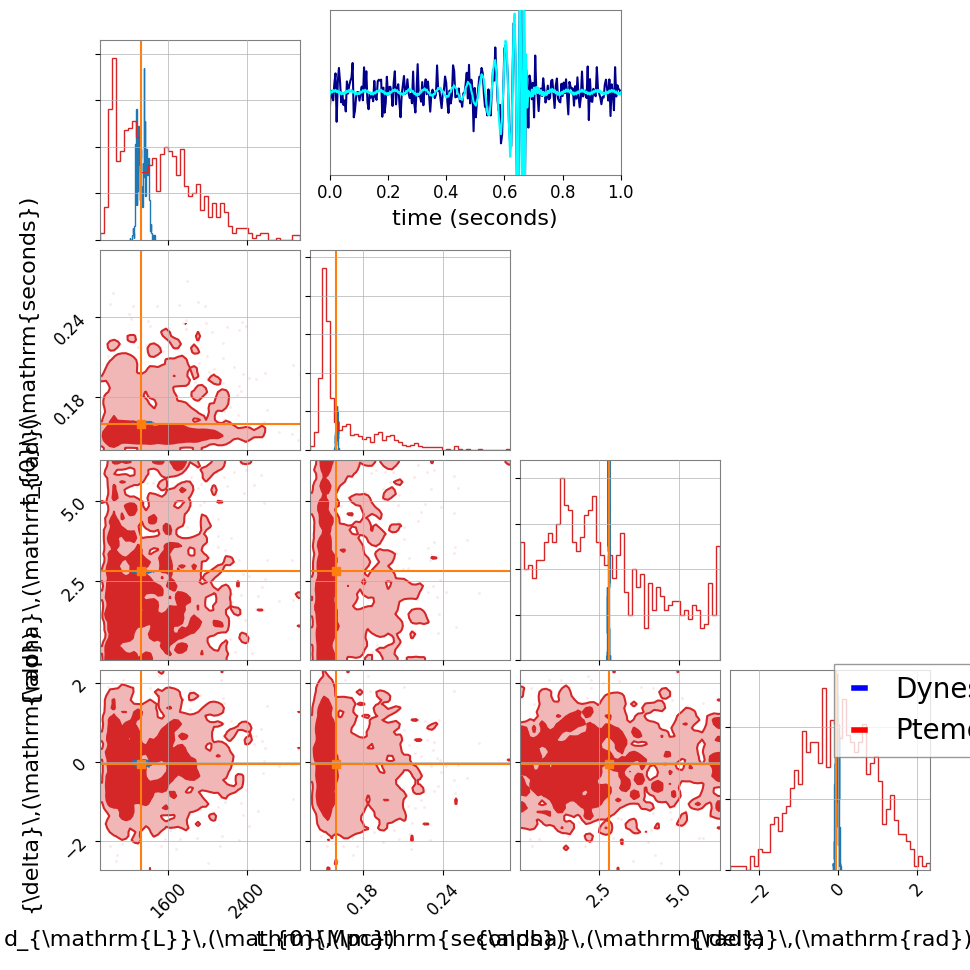

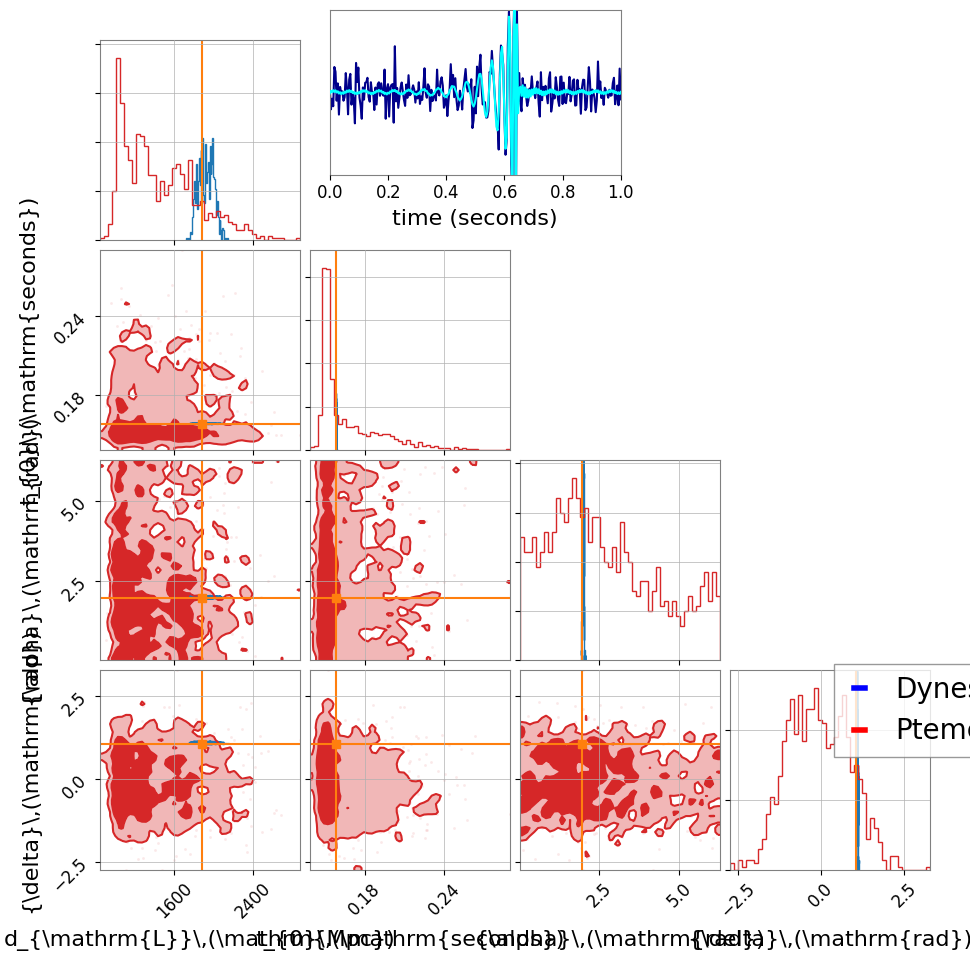

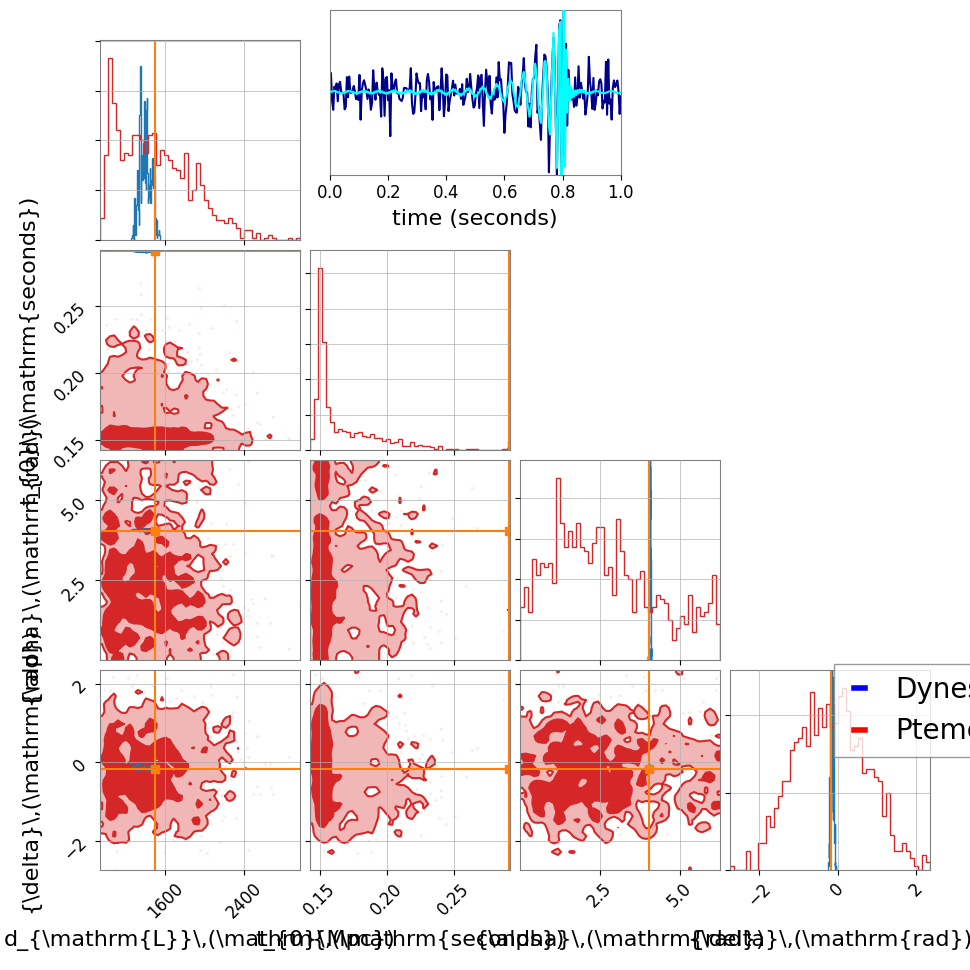

In [0]:
for i in range(params['r']**2):
    display(Image(filename='%s/latest_%s/corner_plot_%s_%d.png' % (params['plot_dir'],params['run_label'],params['run_label'],i))) 

KL plot:

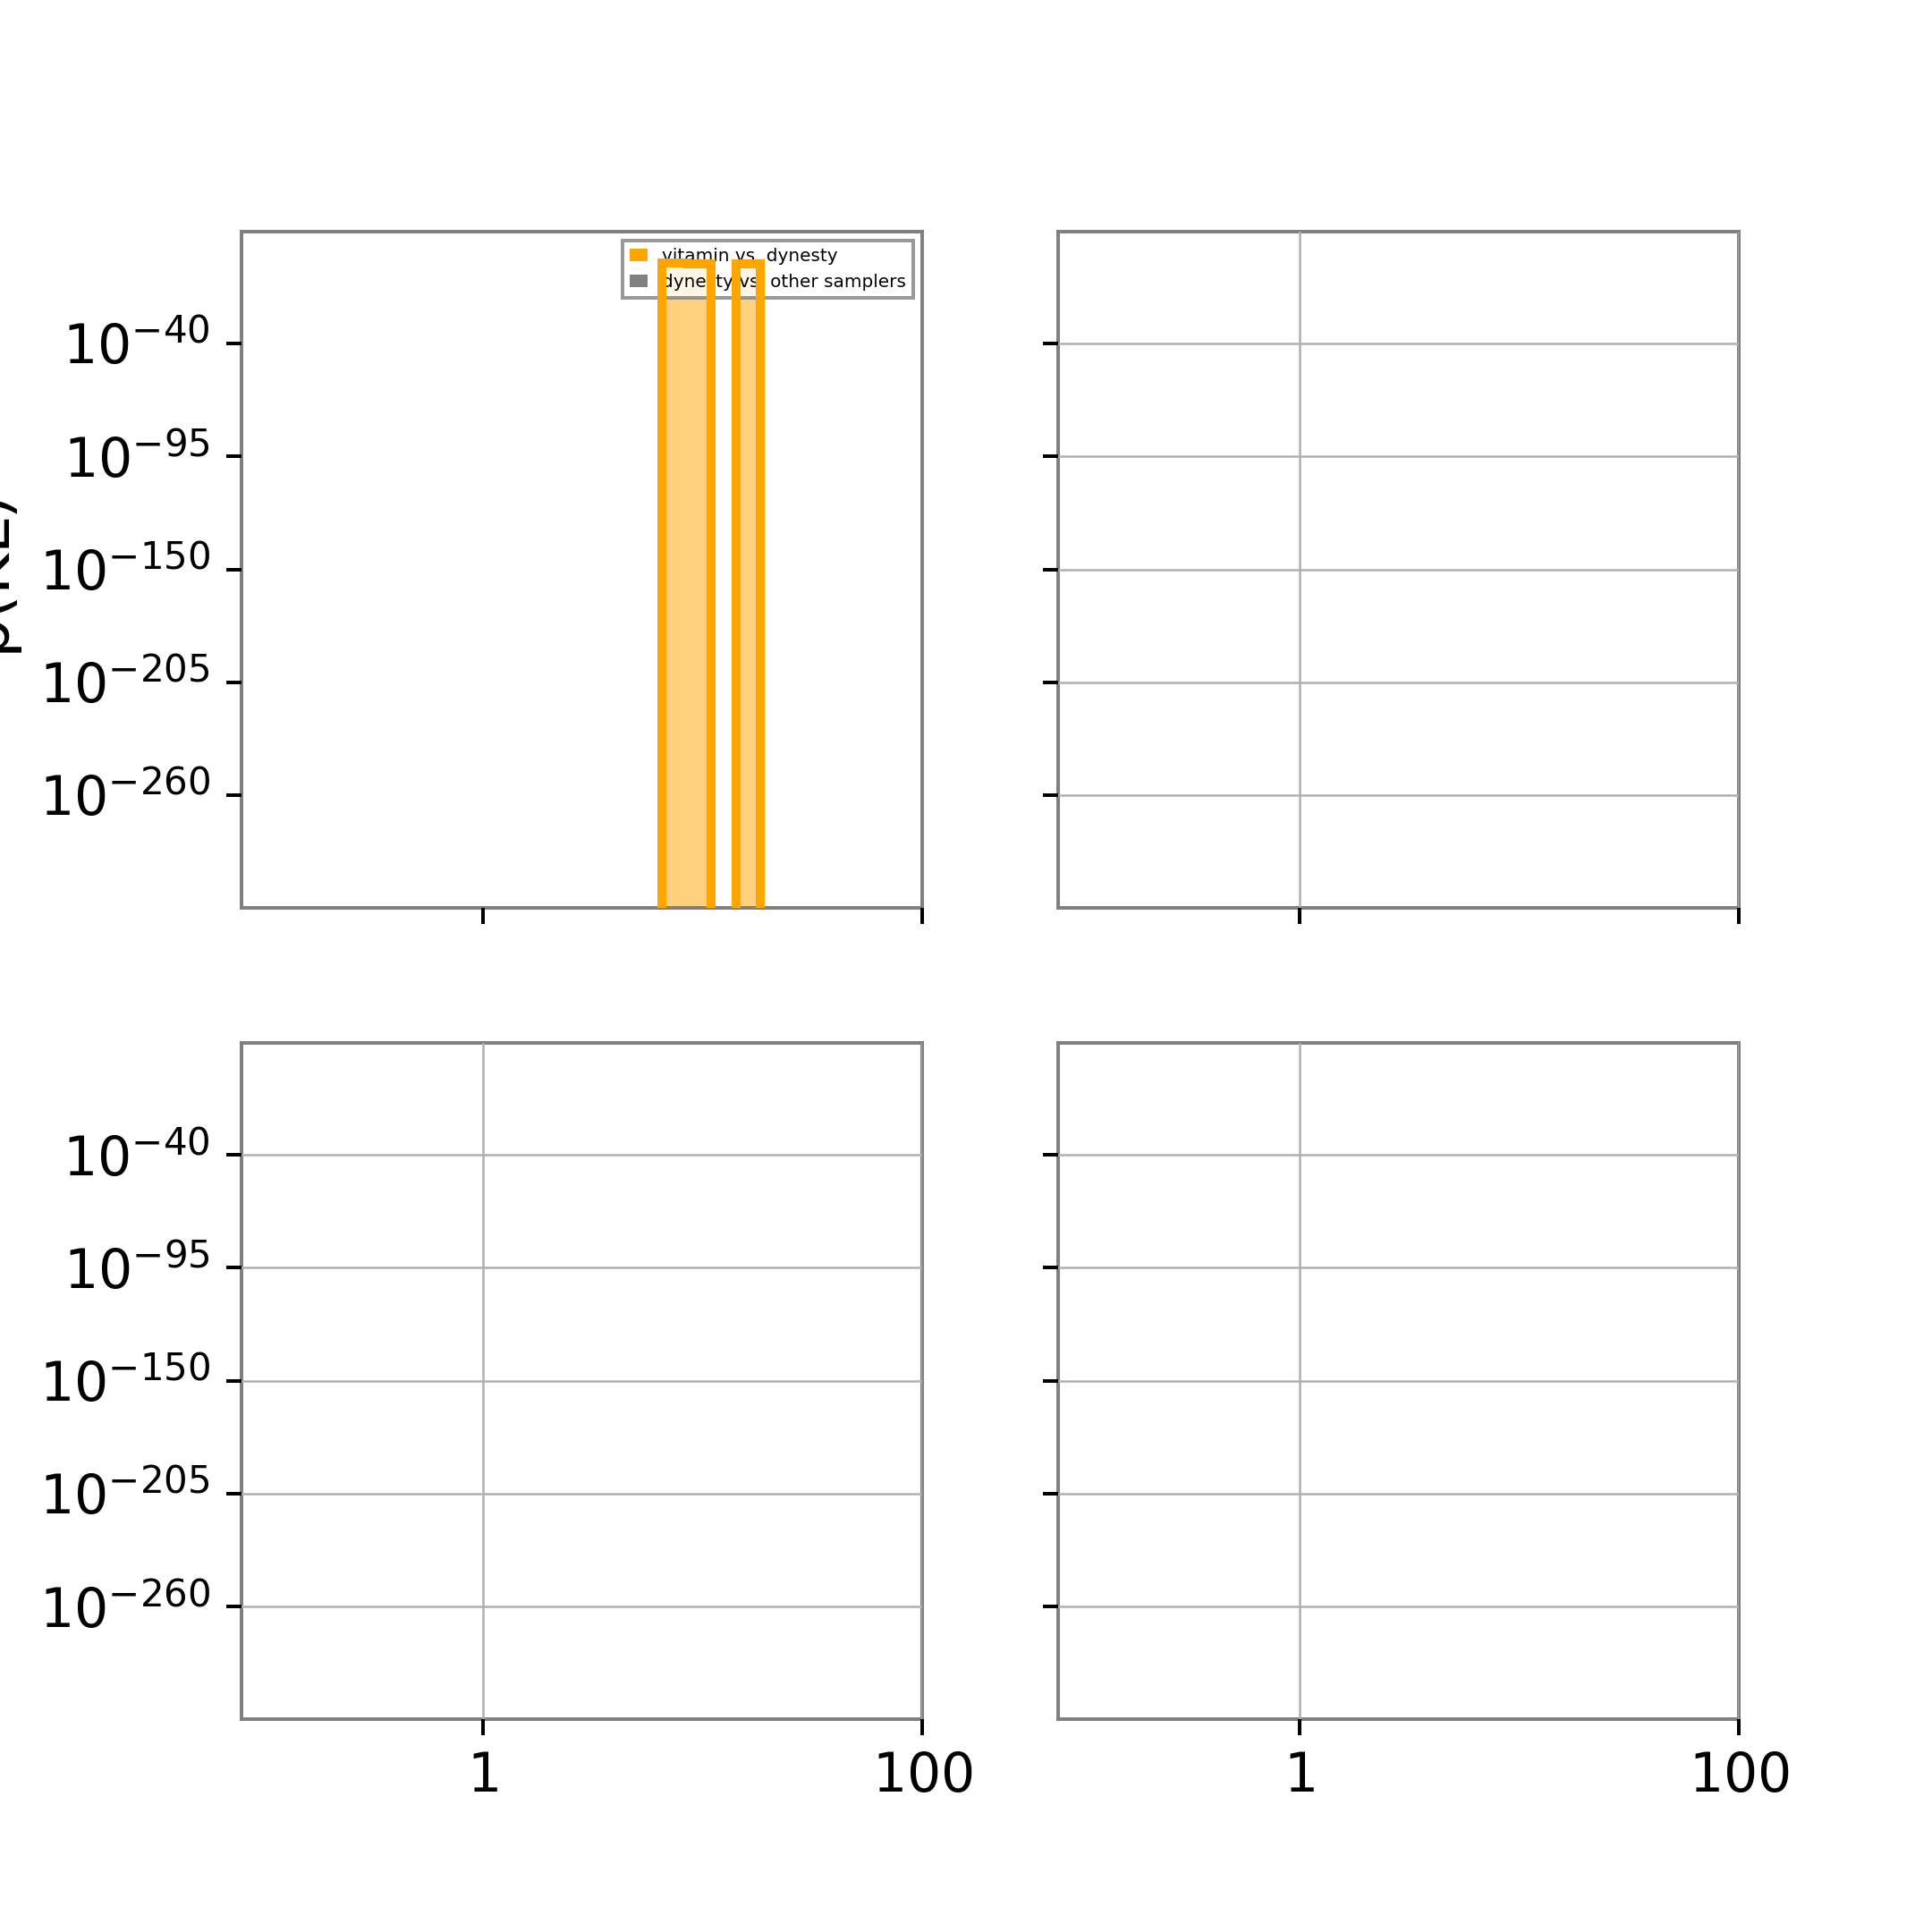

In [0]:
Image(filename='%s/latest_%s/hist-kl.png' % (params['plot_dir'],params['run_label']))

P-P plot:

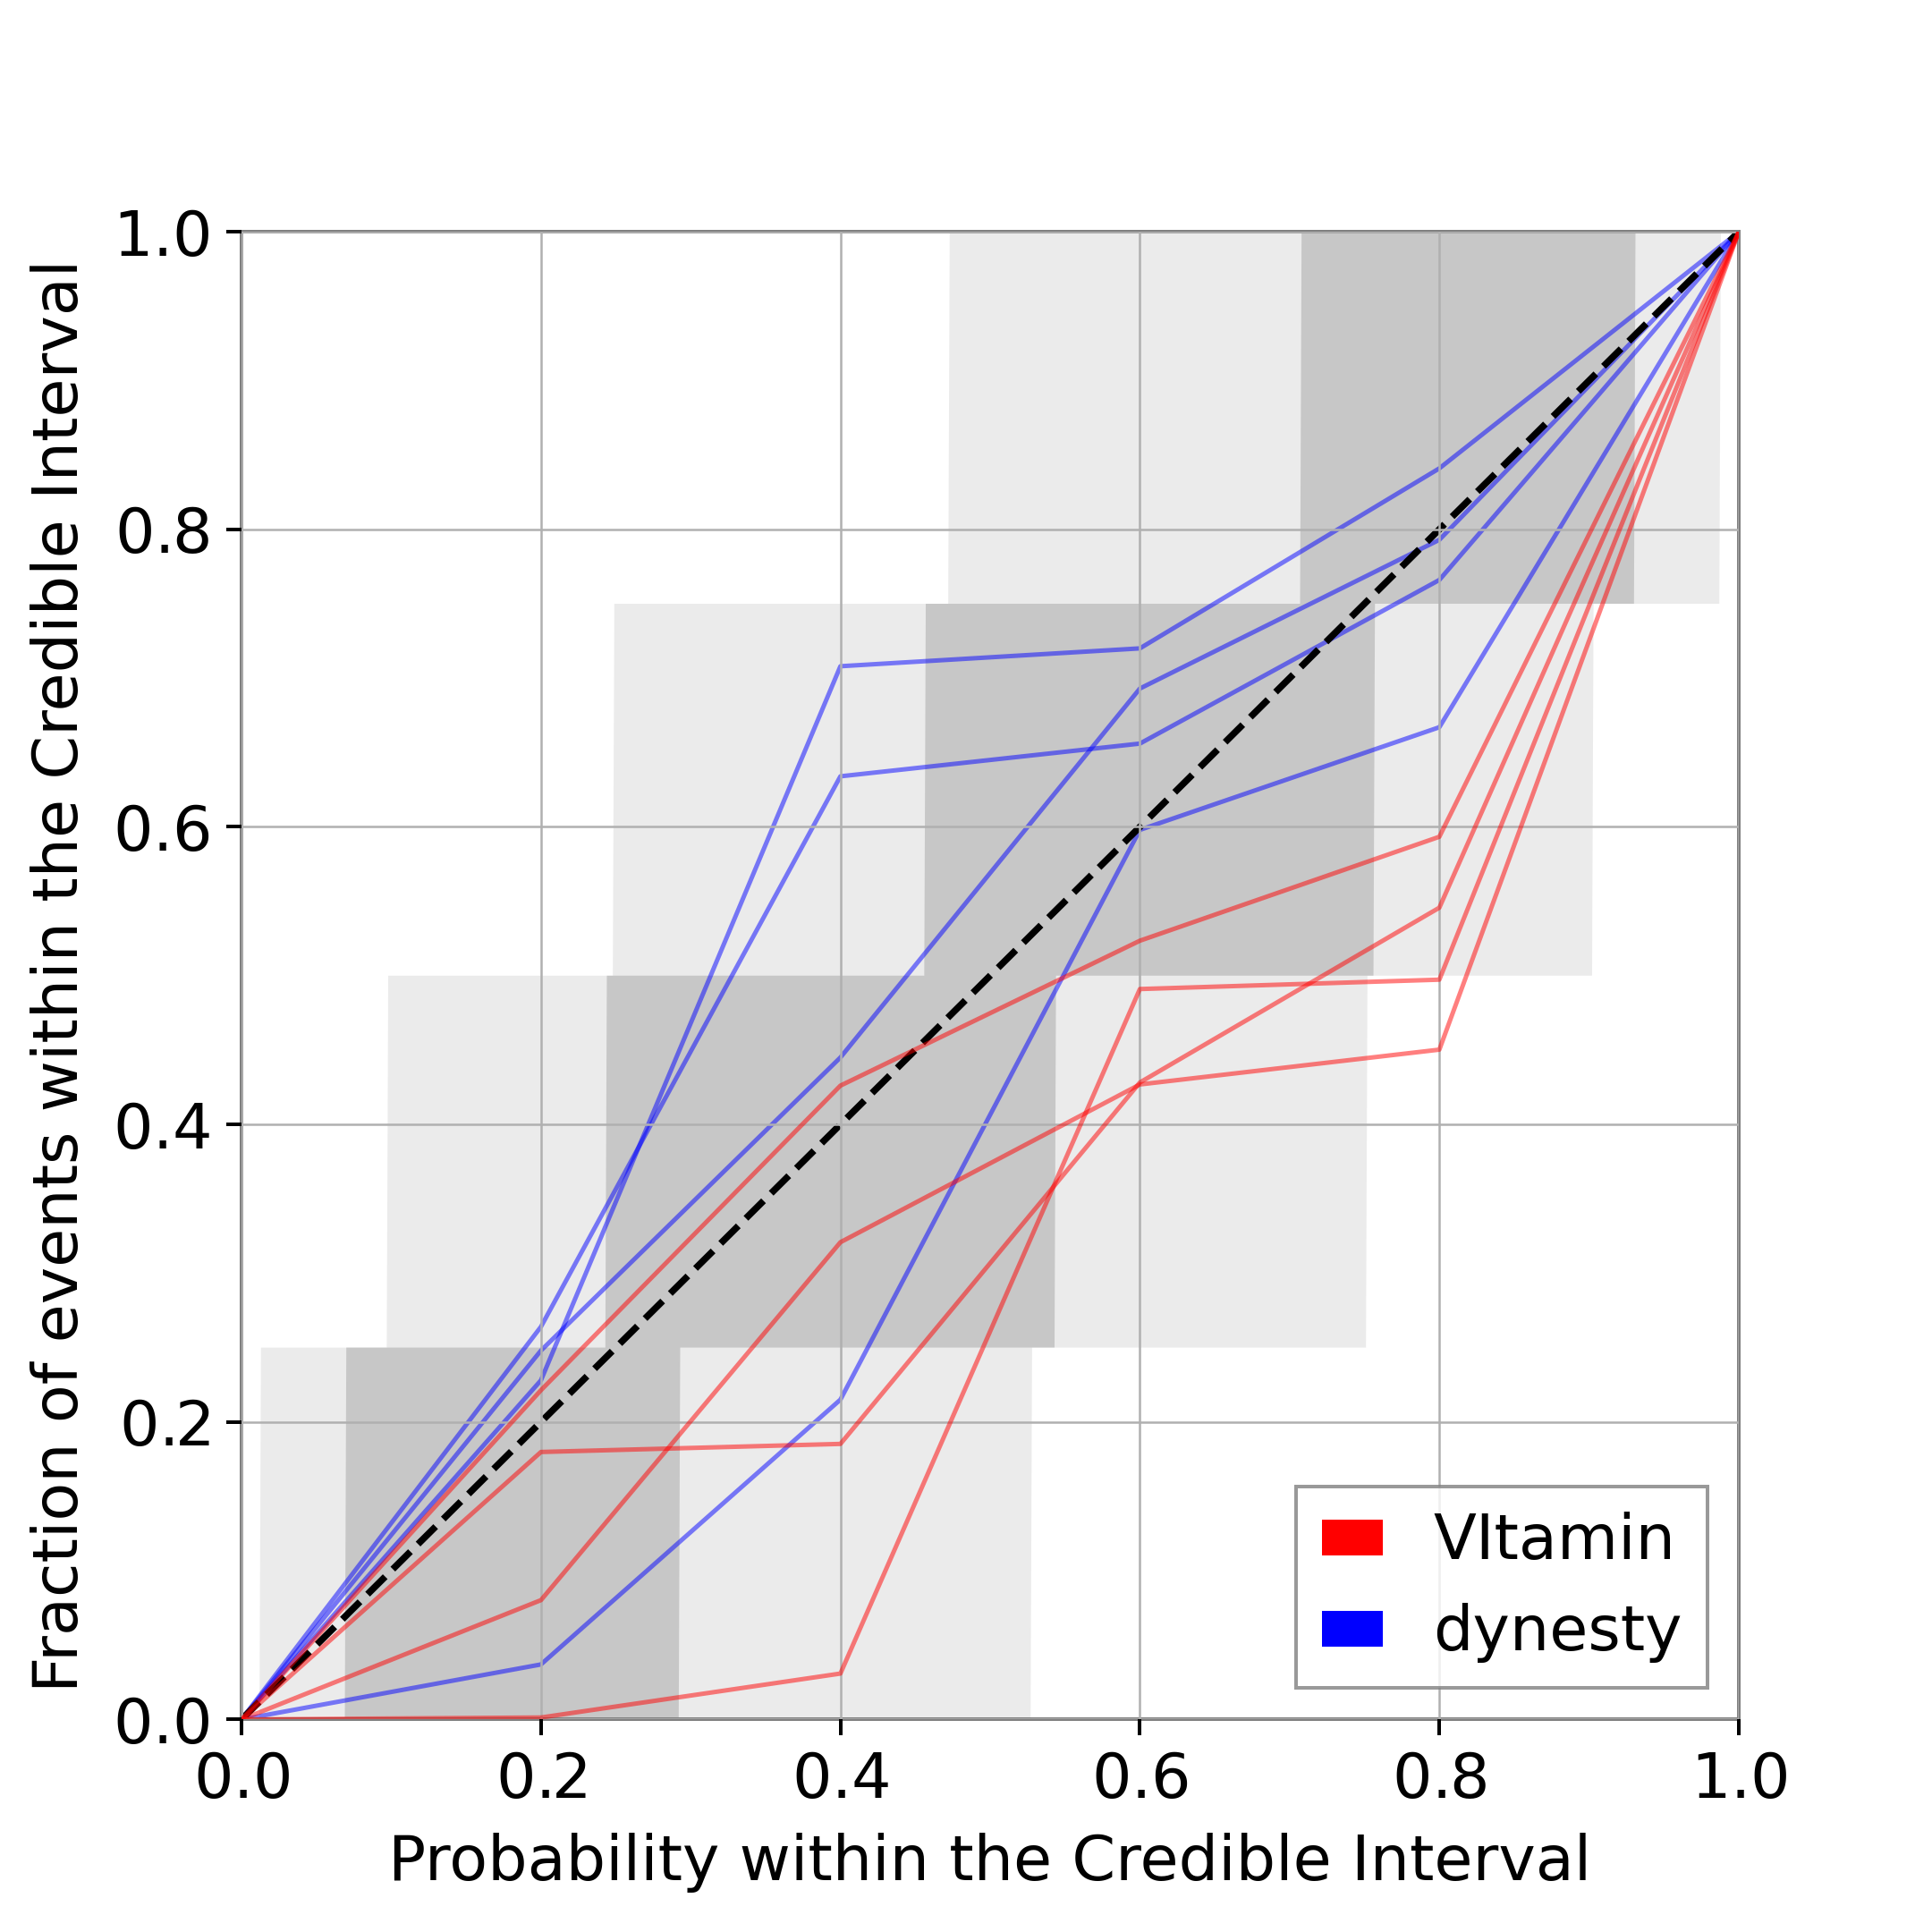

In [0]:
Image(filename='%s/latest_%s/latest_pp_plot.png' % (params['plot_dir'],params['run_label']))

### Optimal results example

Eventually, you want to get results that look like the following:

bilby_pe.py
inverse_model_dir_ozgrav-demo_3det_9par_256Hz_run1/
LICENSE
Models/
Neural_Networks/
OzGrav_VItamin_demo.ipynb
params_ozgrav-demo_3det_9par_256Hz_run1_bounds.txt
params_ozgrav-demo_3det_9par_256Hz_run1_fixed_vals.txt
params_ozgrav-demo_3det_9par_256Hz_run1.txt
plotsky.py
plots.py
__pycache__/
README.md
requirements.txt
results/
test_sets/
training_sets_3det_9par_256Hz/
VICI_code_usage_example.py


# Background

This tutorial is based on the paper Bayesian Parameter Estimation using Conditional Variational Autoencoders for Gravitational-wave Astronomy (https://arxiv.org/abs/1909.06296). In the Background section, I will provide some description on the inner workings of the VItamin code.


**Note: All code cells below are NOT meant to be executable. Just educational.**

---





## Network Training Portion of VItamin

TensorFlow 1.0 requires that we define a TensorFlow session where the computational graph will execute. This is not necessary to do in TensorFlow 2.0. We also need to define place holders for future inputs to be used when we eventually go to train the graph.

In [0]:
graph = tf.Graph()
session = tf.Session(graph=graph)
with graph.as_default():

    # PLACE HOLDERS
    bs_ph = tf.placeholder(dtype=tf.int64, name="bs_ph")                        # batch size placeholder
    x_ph = tf.placeholder(dtype=tf.float32, shape=[None, xsh[1]], name="x_ph")  # params placeholder
    if n_conv_r1 != None:
        if params['by_channel'] == True:
            y_ph = tf.placeholder(dtype=tf.float32, shape=[None,ysh,len(fixed_vals['det'])], name="y_ph") # data placeholder
        else:
            y_ph = tf.placeholder(dtype=tf.float32, shape=[None,len(fixed_vals['det']),ysh], name="y_ph") # data placeholder
    else:
        y_ph = tf.placeholder(dtype=tf.float32, shape=[None,ysh], name="y_ph")  # data placeholder
    idx = tf.placeholder(tf.int32)

Define and import from seperate scripts the three networks we will be training. (i.e. r1,r2 and q)

In [0]:
    # LOAD VICI NEURAL NETWORKS
    r2_xzy = VICI_decoder.VariationalAutoencoder('VICI_decoder', wrap_mask, nowrap_mask, 
                                                  n_input1=z_dimension, n_input2=ysh_conv_r2, n_output=xsh[1], 
                                                  n_weights=n_weights_r2, n_hlayers=n_hlayers_r2, 
                                                  drate=drate, n_filters=n_filters_r2, filter_size=filter_size_r2,
                                                  maxpool=maxpool_r2, n_conv=n_conv_r2, conv_strides=conv_strides_r2, pool_strides=pool_strides_r2, num_det=num_det, batch_norm=batch_norm, by_channel=params['by_channel'], weight_init=params['weight_init'])
    r1_zy = VICI_encoder.VariationalAutoencoder('VICI_encoder', n_input=ysh_conv_r1, n_output=z_dimension, 
                                                  n_weights=n_weights_r1, n_modes=n_modes, 
                                                  n_hlayers=n_hlayers_r1, drate=drate, n_filters=n_filters_r1, 
                                                  filter_size=filter_size_r1,maxpool=maxpool_r1, n_conv=n_conv_r1, conv_strides=conv_strides_r1, pool_strides=pool_strides_r1, num_det=num_det, batch_norm=batch_norm, by_channel=params['by_channel'], weight_init=params['weight_init'])
    q_zxy = VICI_VAE_encoder.VariationalAutoencoder('VICI_VAE_encoder', n_input1=xsh[1], n_input2=ysh_conv_q, 
                                                    n_output=z_dimension, n_weights=n_weights_q, 
                                                    n_hlayers=n_hlayers_q, drate=drate, n_filters=n_filters_q, 
                                                    filter_size=filter_size_q,maxpool=maxpool_q, n_conv=n_conv_q, conv_strides=conv_strides_q, pool_strides=pool_strides_q, num_det=num_det, batch_norm=batch_norm, by_channel=params['by_channel'], weight_init=params['weight_init']) # used to sample from q(z|x,y)?
    tf.set_random_seed(np.random.randint(0,10))

Apply a ramp which is linear in log space on the Kubler-Leibeck divergence term.

In [0]:
    ramp = (tf.log(tf.dtypes.cast(idx,dtype=tf.float32)) - tf.log(ramp_start))/(tf.log(ramp_end)-tf.log(ramp_start))
    ramp = tf.minimum(tf.math.maximum(0.0,ramp),1.0)
        
    if params['ramp'] == False:
        ramp = 1.0

Get the encoder network r1(z|y) latent predicted mean, log variances and mode weights of latent space Gaussian distributions. (i.e. r1(z|y))

*   `r1_loc.shape` = `(batch_size, modes, latent_space_dimensions)`
*   `r1_scale.shape` = `(batch_size, modes, latent_space_dimensions)`
*   `r1_weight.shape` = `(batch_size, modes)`


In [0]:
    # reduce the y data size
    y_conv = y_ph

    # GET r1(z|y)
    # run inverse autoencoder to generate mean and logvar of z given y data - these are the parameters for r1(z|y)
    r1_loc, r1_scale, r1_weight = r1_zy._calc_z_mean_and_sigma(y_conv)
    r1_scale = tf.sqrt(SMALL_CONSTANT + tf.exp(r1_scale))

    # apply KL ramp to r1_weight
    r1_weight = ramp*tf.squeeze(r1_weight)

Key aspect of code. We define a Gaussian mixture model, given predicted means (`r1_loc`), log variances (`r1_scale`) and mode weights (`r1_weight`) from the r1 network. This alows us to generate multi-modal posteriors.

`mixture_distribution` argument tell us the probability that we will draw from a particular mode. `components_distribution` are the components from which we will draw samples.

We can then sample from this distribution in order to get out a single sample from each of the r1 latent space dimensions for every training case in batch (r1_zy_samp).



*   `r1_zy_samp.shape` = `(batch_size, latent_space_dimensions)`



In [0]:
    # define the r1(z|y) mixture model
    bimix_gauss = tfd.MixtureSameFamily(
                      mixture_distribution=tfd.Categorical(logits=ramp*r1_weight),
                      components_distribution=tfd.MultivariateNormalDiag(
                      loc=r1_loc,
                      scale_diag=r1_scale))
    # DRAW FROM r1(z|y) - given the Gaussian parameters generate z samples
    r1_zy_samp = bimix_gauss.sample()  

Calculate the predicted means and log variances of the q network. Given those means and log variances, retrieve a single sample from each latent space dimension in the form of (`q_zxy_samp`).



*   `q_zxy_mean.shape` = `(batch_size, latent_space_dimensions)`
*   `q_zxy_log_sig_sq` = `(batch_size, latent_space_dimensions)`
*   `q_zxy_samp` = `(batch_size, latent_space_dimensions)`



In [0]:
    # GET q(z|x,y)
    q_zxy_mean, q_zxy_log_sig_sq = q_zxy._calc_z_mean_and_sigma(x_ph,y_conv)

    # DRAW FROM q(z|x,y)
    q_zxy_samp = q_zxy._sample_from_gaussian_dist(bs_ph, z_dimension, q_zxy_mean, tf.log(SMALL_CONSTANT + tf.exp(q_zxy_log_sig_sq)))

Retrieve predicted means and standard deviations from r2 network. Identify source parameters to apply Von Mises wrapping to.



*   `r2_xzy_mean_nowrap.shape` = `(batch_size, number_unwrapped_parameters)`
*   `r2_xzy_log_sig_sq_nowrap.shape` = `(batch_size, number_unwrapped_parameters)`
*   `r2_xzy_mean_wrap.shape` = `(batch_size, number_wrapped_parameters)`
*   `r2_xzy_log_sig_sq_wrap.shape` = `(batch_size, number_wrapped_parameters)`



In [0]:
    # GET r2(x|z,y)
    reconstruction_xzy = r2_xzy.calc_reconstruction(q_zxy_samp,y_conv)
    r2_xzy_mean_nowrap = reconstruction_xzy[0]
    r2_xzy_log_sig_sq_nowrap = reconstruction_xzy[1]
    if np.sum(wrap_mask)>0:
        r2_xzy_mean_wrap = reconstruction_xzy[2]
        r2_xzy_log_sig_sq_wrap = reconstruction_xzy[3]

Apply a small normalization factor to predicted means of r2 source parameter predictions (for algebra reasons(normalising_factor_x)). Compute the mean difference between predicted means from r2 and source parameter truths (essentially a mean squared error(square_diff_between_mu_and_x)). Divide the mean difference by the standard deviation squared (inside_exp_x). Apply pre-computed small normalization factor (normalising_factor_x) to pre-computed mean difference (inside_exp_x). 

All this returns the reconstruction loss, or in other words ... how far off the mean locations of the network predicted source parameter Gaussians are from the source parameter truths.

In [0]:
    # COST FROM RECONSTRUCTION - Gaussian parts
    normalising_factor_x = -0.5*tf.log(SMALL_CONSTANT + tf.exp(r2_xzy_log_sig_sq_nowrap)) - 0.5*np.log(2.0*np.pi)   # -0.5*log(sig^2) - 0.5*log(2*pi)
    square_diff_between_mu_and_x = tf.square(r2_xzy_mean_nowrap - tf.boolean_mask(x_ph,nowrap_mask,axis=1))         # (mu - x)^2

    inside_exp_x = -0.5 * tf.divide(square_diff_between_mu_and_x,SMALL_CONSTANT + tf.exp(r2_xzy_log_sig_sq_nowrap)) # -0.5*(mu - x)^2 / sig^2
    reconstr_loss_x = tf.reduce_sum(normalising_factor_x + inside_exp_x,axis=1,keepdims=True)                       # sum_dim(-0.5*log(sig^2) - 0.5*log(2*pi) - 0.5*(mu - x)^2 / sig^2)

We use Von Mises distribution, rather than a Gaussian, on source parameters we know to have periodic-like distributions. `con` is the concentration of the distribtion (similar to standard deviation parameter in Gaussian). `loc` is the circular mean of the distribution (similar the the mean of a Gaussian).

We get out a loss for Von Mises parameters by computing the log probability of the distribution evaluated at the source parameter truths.



In [0]:
    # COST FROM RECONSTRUCTION - Von Mises parts
    if np.sum(wrap_mask)>0:
        con = tf.reshape(tf.math.reciprocal(SMALL_CONSTANT + tf.exp(r2_xzy_log_sig_sq_wrap)),[-1,wrap_len])                                             # modelling wrapped scale output as log variance
        von_mises = tfp.distributions.VonMises(loc=2.0*np.pi*(tf.reshape(r2_xzy_mean_wrap,[-1,wrap_len])-0.5), concentration=con)                       # define p_vm(2*pi*mu,con=1/sig^2)
        reconstr_loss_vm = tf.reduce_sum(von_mises.log_prob(2.0*np.pi*(tf.reshape(tf.boolean_mask(x_ph,wrap_mask,axis=1),[-1,wrap_len]) - 0.5)),axis=1) # 2pi is the von mises input range
        r2_xzy_mean = tf.gather(tf.concat([r2_xzy_mean_nowrap,r2_xzy_mean_wrap],axis=1),tf.constant(idx_mask),axis=1)
        r2_xzy_scale = tf.gather(tf.concat([r2_xzy_log_sig_sq_nowrap,r2_xzy_log_sig_sq_wrap],axis=1),tf.constant(idx_mask),axis=1) 
        cost_R = -1.0*tf.reduce_mean(reconstr_loss_x + reconstr_loss_vm)                                                                                # average over batch
    else:
        cost_R = -1.0*tf.reduce_mean(reconstr_loss_x)    
        r2_xzy_mean = r2_xzy_mean_nowrap
        r2_xzy_scale = r2_xzy_log_sig_sq_nowrap

Compute the level of uncertainty in q. Basically do the same set of operations done on r2 earlier. Compute mean squared difference between predicted means from q and samples of the latent space from q and normalize. Essentially, we don't want the locations of the predicted latent space Gaussian to be all over the place. We want them to settle into a local minimum.

In [0]:
    # compute montecarlo KL - first compute the analytic self entropy of q 
    normalising_factor_kl = -0.5*tf.log(SMALL_CONSTANT + tf.exp(q_zxy_log_sig_sq)) - 0.5*np.log(2.0*np.pi)   # -0.5*log(sig^2) - 0.5*log(2*pi)
    square_diff_between_qz_and_q = tf.square(q_zxy_mean - q_zxy_samp)                                        # (mu - x)^2
    inside_exp_q = -0.5 * tf.divide(square_diff_between_qz_and_q,SMALL_CONSTANT + tf.exp(q_zxy_log_sig_sq))  # -0.5*(mu - x)^2 / sig^2
    log_q_q = tf.reduce_sum(normalising_factor_kl + inside_exp_q,axis=1,keepdims=True)                       # sum_dim(-0.5*log(sig^2) - 0.5*log(2*pi) - 0.5*(mu - x)^2 / sig^2)

Calculate the mean KL divergence between the sum of the uncertainty in q over the whole batch and log probability of r1 at q samples over the whole batch.

In [0]:
    log_r1_q = bimix_gauss.log_prob(q_zxy_samp)   # evaluate the log prob of r1 at the q samples
    KL = tf.reduce_mean(log_q_q - log_r1_q)      # average over batch

Get total loss of network by adding KL divergence (scaled by a ramp factor) to the reconstruction loss.

In [0]:
    # THE VICI COST FUNCTION
    COST = cost_R + ramp*KL

Colate all variables (weights, biases, etc.) of the network into a list. Define an optimizer to use. Initialize and run the whole session. Define function to save network.

In [0]:
    # VARIABLES LISTS
    var_list_VICI = [var for var in tf.trainable_variables() if var.name.startswith("VICI")]
        
    # DEFINE OPTIMISER (using ADAM here)
    optimizer = tf.train.AdamOptimizer(params['initial_training_rate']) 
    minimize = optimizer.minimize(COST,var_list = var_list_VICI)
        
    # INITIALISE AND RUN SESSION
    init = tf.global_variables_initializer()
    session.run(init)
    saver = tf.train.Saver()

Train the network graph

In [0]:
print('Training Inference Model...')    
# START OPTIMISATION OF OELBO
indices_generator = batch_manager.SequentialIndexer(params['batch_size'], xsh[0])

load_chunk_it = 1
# Iterate over requested number of training iterations
for i in range(params['num_iterations']):

    next_indices = indices_generator.next_indices()

    # if load chunks true, load in data by chunks
    if params['load_by_chunks'] == True and i == int(params['load_iteration']*load_chunk_it):
        x_data, y_data = load_chunk(params['train_set_dir'],params['inf_pars'],params,bounds,fixed_vals)
        load_chunk_it += 1

    # Make noise realizations and add to training data
    next_x_data = x_data[next_indices,:]
    if n_conv_r1 != None:
        next_y_data = y_data[next_indices,:] + np.random.normal(0,1,size=(params['batch_size'],int(params['ndata']),len(fixed_vals['det'])))
    else:
        next_y_data = y_data[next_indices,:] + np.random.normal(0,1,size=(params['batch_size'],int(params['ndata']*len(fixed_vals['det']))))
    next_y_data /= y_normscale  # required for fast convergence

    if params['by_channel'] == False:
        next_y_data_new = [] 
        for sig in next_y_data:
            next_y_data_new.append(sig.T)
        next_y_data = np.array(next_y_data_new)
        del next_y_data_new
       
    # restore session if wanted
    if params['resume_training'] == True and i == 0 :
        print(save_dir)
        saver.restore(session, save_dir)
 
    # train to minimise the cost function
    session.run(minimize, feed_dict={bs_ph:bs, x_ph:next_x_data, y_ph:next_y_data, idx:i})

## Q network
Encoder network which takes as input time series and source parameter truths. Outputs samples from q network latent space.


### Define initial variables

In [0]:
class VariationalAutoencoder(object):

    def __init__(self, name, n_input1=3, n_input2=256, n_output=4, n_weights=2048, n_hlayers=2, drate=0.2, n_filters=8, filter_size=8, maxpool=4, n_conv=2, conv_strides=1, pool_strides=1, num_det=1, batch_norm=False, by_channel=False, weight_init='xavier'):
        
        self.n_input1 = n_input1                                                # latent space dimension size
        self.n_input2 = n_input2                                                # time series size
        self.n_output = n_output                                                # number of source parameters to infer
        self.n_weights = n_weights                                              # number of fully-connected neurons in each layer
        self.n_hlayers = n_hlayers                                              # number of fully-connected layers
        self.n_conv = n_conv                                                    # number of convolutional layers
        self.drate = drate                                                      # drop out rate in fully-connected layers
        self.n_filters = n_filters                                              # number of filters in each convolutional layer
        self.filter_size = filter_size                                          # size of filters in each convolutional layer
        self.maxpool = maxpool                                                  # maxpooling size in each layer
        self.conv_strides = conv_strides                                        # convolutional stride size in each layer
        self.pool_strides = pool_strides                                        # max pool stride size in each layer
        self.num_det = num_det                                                  # number of detectors used
        self.batch_norm = batch_norm                                            # batch normalization on or off in each layer
        self.by_channel = by_channel                                            # whether or not to split input up into seperate channels
        self.weight_init = weight_init                                          # type of weight initilization to use
        network_weights = self._create_weights()                                # initialize the network weights and biases
        self.weights = network_weights                                          # store intialized network weights
        self.nonlinearity = tf.nn.relu                                          # activation function to use in-between layers

### Define network archetecture

In [0]:
    def _calc_z_mean_and_sigma(self,x,y):
        with tf.name_scope("VICI_VAE_encoder"):

            # Add convolutional layers if wanted
            if self.n_conv is not None:

                # Reshape input to a multi-dimensional tensor - single channel
                if self.by_channel == True:
                    conv_pool = tf.reshape(y, shape=[-1, 1, y.shape[1], self.num_det])

                    # Append requested number of convolutional layers to network
                    for i in range(self.n_conv):
                        weight_name = 'w_conv_' + str(i)
                        bias_name = 'b_conv_' + str(i)
                        conv_pre = tf.add(tf.nn.conv2d(conv_pool,               # Add convolutional layer
                                          self.weights['VICI_VAE_encoder'][weight_name],
                                          strides=[1,1,self.conv_strides[i],1],padding='SAME'),
                                          self.weights['VICI_VAE_encoder'][bias_name])
                        conv_post = self.nonlinearity(conv_pre)                 # Add non-linear activation function

                        # Apply batch normalization if wanted
                        if self.batch_norm == True:
                            conv_batchNorm = tf.nn.batch_normalization(conv_post,
                                             tf.Variable(tf.zeros([1,conv_post.shape[2],conv_post.shape[3]], 
                                             dtype=tf.float32)),tf.Variable(tf.ones([1,conv_post.shape[2],conv_post.shape[3]], 
                                             dtype=tf.float32)),None,None,0.000001)
                            conv_dropout = tf.layers.dropout(conv_batchNorm,    # Apply dropout to layer
                                                             rate=self.drate)
                        else:
                            conv_dropout = tf.layers.dropout(conv_post,         # Apply droptout to layer
                                                             rate=self.drate)
                        conv_pool = tf.nn.max_pool(conv_dropout,ksize=[1, 1,    # Add max pooling layer
                                                   self.maxpool[i], 1],
                                                   strides=[1, 1, self.pool_strides[i], 1],
                                                   padding='SAME')

                    fc = tf.concat([x,tf.reshape(conv_pool, 
                                                 [-1, int(conv_pool.shape[2]*conv_pool.shape[3])])],axis=1)

                # Otherwise, reshape input into 1D tensor - multiple channels 
                if self.by_channel == False:
                    conv_pool = tf.reshape(y, shape=[-1, y.shape[1], y.shape[2], 1])

                    # Append requested number of convolutional layers to network
                    for i in range(self.n_conv):
                        weight_name = 'w_conv_' + str(i)
                        bias_name = 'b_conv_' + str(i)
                        conv_pre = tf.add(tf.nn.conv2d(conv_pool, self.weights['VICI_VAE_encoder'][weight_name],strides=[1,self.conv_strides[i],self.conv_strides[i],1],padding='SAME'),self.weights['VICI_VAE_encoder'][bias_name])
                        conv_post = self.nonlinearity(conv_pre)
                        if self.batch_norm == True:
                            conv_batchNorm = tf.nn.batch_normalization(conv_post,tf.Variable(tf.zeros([conv_post.shape[1],conv_post.shape[2],conv_post.shape[3]], dtype=tf.float32)),tf.Variable(tf.ones([conv_post.shape[1],conv_post.shape[2],conv_post.shape[3]], dtype=tf.float32)),None,None,0.000001)
                        conv_pool = tf.nn.max_pool(conv_batchNorm,ksize=[1, self.maxpool[i], self.maxpool[i], 1],strides=[1, self.pool_strides[i], self.pool_strides[i], 1],padding='SAME')

                    fc = tf.concat([x,tf.reshape(conv_pool, [-1, int(conv_pool.shape[1]*conv_pool.shape[2]*conv_pool.shape[3])])],axis=1)

            # If no convolutional filters wanted, just use fully-connected layers
            else:
                fc = tf.concat([x,y],axis=1)

            # Append requested number of fully-connected layers
            hidden_dropout = fc
            for i in range(self.n_hlayers):
                weight_name = 'w_hidden_' + str(i)
                bias_name = 'b_hidden' + str(i)
                hidden_pre = tf.add(tf.matmul(hidden_dropout,                   # Add fully connected layer 
                             self.weights['VICI_VAE_encoder'][weight_name]), 
                             self.weights['VICI_VAE_encoder'][bias_name])
                hidden_post = self.nonlinearity(hidden_pre)                     # Add non-linear activation function

                # Add batch normalization if requested by the user
                if self.batch_norm == True:
                    hidden_batchNorm = tf.nn.batch_normalization(hidden_post,tf.Variable(tf.zeros([hidden_post.shape[1]], dtype=tf.float32)),tf.Variable(tf.ones([hidden_post.shape[1]], dtype=tf.float32)),None,None,0.000001)
                    hidden_dropout = tf.layers.dropout(hidden_batchNorm,rate=self.drate)
                else:
                    hidden_dropout = tf.layers.dropout(hidden_post,rate=self.drate)

            # Network returns a mean (loc) and a variance (scale)
            loc = tf.add(tf.matmul(hidden_dropout, self.weights['VICI_VAE_encoder']['w_loc']), self.weights['VICI_VAE_encoder']['b_loc'])
            scale = tf.add(tf.matmul(hidden_dropout, self.weights['VICI_VAE_encoder']['w_scale']), self.weights['VICI_VAE_encoder']['b_scale'])

            tf.summary.histogram('loc', loc)
            tf.summary.histogram('scale', scale)
            return loc, scale

### Define function to sample from network predicted Gaussian's

In [0]:
    def _sample_from_gaussian_dist(self, num_rows, num_cols, mean, log_sigma_sq):
        """ Function to draw samples from NN predicted Gaussians.
        """
        with tf.name_scope("sample_in_z_space"):                                # Just a naming mechanism which labels this operation in the graph
            eps = tf.random_normal([num_rows, num_cols], 0, 1.,                 # Define random locations from Gaussian to sample 
                                   dtype=tf.float32)
            sample = tf.add(mean, tf.multiply(tf.sqrt(tf.exp(log_sigma_sq)),    #  
                                              eps))
        return sample

### Define function to initialize weights

In [0]:
    def _create_weights(self):
        """ Function to initialize weights of layers
        """
        all_weights = collections.OrderedDict()
        with tf.variable_scope("VICI_VAE_ENC"):                                 # Just a naming mechanism (doesn't do much)
            # Encoder 
            all_weights['VICI_VAE_encoder'] = collections.OrderedDict()         # Define dictionary to store network weights
            
            # Define convolutional weights
            if self.n_conv is not None:
                dummy = 1
                
                # Iterate over requested number of convolutional layers
                for i in range(self.n_conv):
                    weight_name = 'w_conv_' + str(i)
                    bias_name = 'b_conv_' + str(i)
                    # orthogonal init
                    if self.weight_init == 'Orthogonal':
                        shape_init = (self.filter_size[i],dummy*self.n_filters[i])
                        initializer = tf.keras.initializers.Orthogonal()
                        all_weights['VICI_VAE_encoder'][weight_name] = tf.Variable(tf.reshape(initializer(shape=shape_init),[self.filter_size[i], 1, dummy, self.n_filters[i]]), dtype=tf.float32)
                    # Variance scaling
                    if self.weight_init == 'VarianceScaling':
                        shape_init = (self.filter_size[i],dummy*self.n_filters[i])
                        initializer = tf.keras.initializers.VarianceScaling()
                        all_weights['VICI_VAE_encoder'][weight_name] = tf.Variable(tf.reshape(initializer(shape=shape_init),[self.filter_size[i], 1, dummy, self.n_filters[i]]), dtype=tf.float32)
                    # xavier initilization
                    if self.weight_init == 'xavier':
                        all_weights['VICI_VAE_encoder'][weight_name] = tf.Variable(tf.reshape(vae_utils.xavier_init(self.filter_size[i], dummy*self.n_filters[i]),[self.filter_size[i], 1, dummy, self.n_filters[i]]), dtype=tf.float32)
                    all_weights['VICI_VAE_encoder'][bias_name] = tf.Variable(tf.zeros([self.n_filters[i]], dtype=tf.float32))
                    tf.summary.histogram(weight_name, all_weights['VICI_VAE_encoder'][weight_name])
                    tf.summary.histogram(bias_name, all_weights['VICI_VAE_encoder'][bias_name])
                    dummy = self.n_filters[i]

                # Determine correct input size to fully-connected layers after having flattened final convolutional layer
                total_pool_stride_sum = 0
                for j in range(len(self.maxpool)):
                    if self.maxpool[j] != 1 and self.pool_strides[j] != 1:
                        total_pool_stride_sum += 1
                    else:
                        if self.maxpool[j] != 1:
                            total_pool_stride_sum += 1
                        if self.pool_strides[j] != 1:
                            total_pool_stride_sum += 1
                    if self.conv_strides[j] != 1:
                        total_pool_stride_sum += 1
                if self.by_channel == True:
                    fc_input_size = self.n_input1 + int(self.n_input2*self.n_filters[i]/(2**total_pool_stride_sum))
                else:
                    fc_input_size = self.n_input1 + int(self.n_input2*self.n_filters[i]/(2**total_pool_stride_sum)*2) 
 
            # If no convolutional layers, give input directly to fully-connected layers
            else:
                fc_input_size = self.n_input1 + self.n_input2

            # Iterate over fully-connected layers
            for i in range(self.n_hlayers):
                weight_name = 'w_hidden_' + str(i)
                bias_name = 'b_hidden' + str(i)
                all_weights['VICI_VAE_encoder'][weight_name] = tf.Variable(vae_utils.xavier_init(fc_input_size, self.n_weights[i]), dtype=tf.float32)
                all_weights['VICI_VAE_encoder'][bias_name] = tf.Variable(tf.zeros([self.n_weights[i]], dtype=tf.float32))
                tf.summary.histogram(weight_name, all_weights['VICI_VAE_encoder'][weight_name])
                tf.summary.histogram(bias_name, all_weights['VICI_VAE_encoder'][bias_name])
                fc_input_size = self.n_weights[i]
                
            # Define weights and biases of final layer where mean and variance of Gaussians is predicted
            all_weights['VICI_VAE_encoder']['w_loc'] = tf.Variable(vae_utils.xavier_init(self.n_weights[-1], self.n_output),dtype=tf.float32)
            all_weights['VICI_VAE_encoder']['b_loc'] = tf.Variable(tf.zeros([self.n_output], dtype=tf.float32), dtype=tf.float32)
            tf.summary.histogram('w_loc', all_weights['VICI_VAE_encoder']['w_loc'])
            tf.summary.histogram('b_loc', all_weights['VICI_VAE_encoder']['b_loc'])
            all_weights['VICI_VAE_encoder']['w_scale'] = tf.Variable(vae_utils.xavier_init(self.n_weights[-1], self.n_output),dtype=tf.float32)
            all_weights['VICI_VAE_encoder']['b_scale'] = tf.Variable(tf.zeros([self.n_output], dtype=tf.float32), dtype=tf.float32)
            tf.summary.histogram('w_scale', all_weights['VICI_VAE_encoder']['w_scale'])
            tf.summary.histogram('b_scale', all_weights['VICI_VAE_encoder']['b_scale'])

            all_weights['prior_param'] = collections.OrderedDict()
        
        return all_weights

## R1 network
Encoder network which takes as input time series only. Outputs latent space samples.

In [0]:
class VariationalAutoencoder(object):

    def __init__(self, name, n_input=256, n_output=4, n_weights=2048, n_modes=2, n_hlayers=2, drate=0.2, n_filters=8, filter_size=8, maxpool=4, n_conv=2, conv_strides=1, pool_strides=1, num_det=1, batch_norm=False, by_channel=False, weight_init='xavier'):
        
        self.n_input = n_input
        self.n_output = n_output
        self.n_weights = n_weights
        self.n_filters = n_filters
        self.filter_size = filter_size
        self.n_hlayers = n_hlayers
        self.n_conv = n_conv
        self.n_modes = n_modes
        self.drate = drate
        self.maxpool = maxpool
        self.conv_strides = conv_strides
        self.pool_strides = pool_strides
        self.num_det = num_det
        self.batch_norm = batch_norm
        self.by_channel = by_channel
        self.weight_init = weight_init

        network_weights = self._create_weights()
        self.weights = network_weights


        self.nonlinearity = tf.nn.relu
        self.nonlinearity_mean = tf.clip_by_value

    def _calc_z_mean_and_sigma(self,x):
        with tf.name_scope("VICI_encoder"):
 
            # Reshape input to a 3D tensor - single channel
            if self.n_conv is not None:
                if self.by_channel == True:
                    conv_pool = tf.reshape(x, shape=[-1, 1, x.shape[1], self.num_det])

                    # network for messing with kernel size
                    for i in range(self.n_conv):
                        weight_name = 'w_conv_' + str(i)
                        bias_name = 'b_conv_' + str(i)
                        conv_pre = tf.add(tf.nn.conv2d(conv_pool, self.weights['VICI_encoder'][weight_name],strides=[1,1,self.conv_strides[i],1],padding='SAME'),self.weights['VICI_encoder'][bias_name])
                        conv_post = self.nonlinearity(conv_pre)
                        if self.batch_norm == True:
                            conv_batchNorm = tf.nn.batch_normalization(conv_post,tf.Variable(tf.zeros([1,conv_post.shape[2],conv_post.shape[3]], dtype=tf.float32)),tf.Variable(tf.ones([1,conv_post.shape[2],conv_post.shape[3]], dtype=tf.float32)),None,None,0.000001)
                            conv_dropout = tf.layers.dropout(conv_batchNorm,rate=self.drate)
                        else:
                            conv_dropout = tf.layers.dropout(conv_post,rate=self.drate)
                        conv_pool = tf.nn.max_pool(conv_dropout,ksize=[1, 1, self.maxpool[i], 1],strides=[1, 1, self.pool_strides[i], 1],padding='SAME')
                    
                    fc = tf.reshape(conv_pool, [-1, int(conv_pool.shape[2]*conv_pool.shape[3])])
                if self.by_channel == False:
                    conv_pool = tf.reshape(x, shape=[-1, x.shape[1], x.shape[2], 1])

                    # network for messing with kernel size
                    for i in range(self.n_conv):
                        weight_name = 'w_conv_' + str(i)
                        bias_name = 'b_conv_' + str(i)
                        conv_pre = tf.add(tf.nn.conv2d(conv_pool, self.weights['VICI_encoder'][weight_name],strides=[1,self.conv_strides[i],self.conv_strides[i],1],padding='SAME'),self.weights['VICI_encoder'][bias_name])
                        conv_post = self.nonlinearity(conv_pre)
                        if self.batch_norm == True:
                            conv_batchNorm = tf.nn.batch_normalization(conv_post,tf.Variable(tf.zeros([conv_post.shape[1],conv_post.shape[2],conv_post.shape[3]], dtype=tf.float32)),tf.Variable(tf.ones([conv_post.shape[1],conv_post.shape[2],conv_post.shape[3]], dtype=tf.float32)),None,None,0.000001)
                        conv_pool = tf.nn.max_pool(conv_batchNorm,ksize=[1, self.maxpool[i], self.maxpool[i], 1],strides=[1, self.pool_strides[i], self.pool_strides[i], 1],padding='SAME')

                    fc = tf.reshape(conv_pool, [-1, int(conv_pool.shape[1]*conv_pool.shape[2]*conv_pool.shape[3])])
            else:
                fc = x

            hidden_dropout = fc
            for i in range(self.n_hlayers):
                weight_name = 'w_hidden_' + str(i)
                bias_name = 'b_hidden' + str(i)
                hidden_pre = tf.add(tf.matmul(hidden_dropout, self.weights['VICI_encoder'][weight_name]), self.weights['VICI_encoder'][bias_name])
                hidden_post = self.nonlinearity(hidden_pre)
                if self.batch_norm == True:
                    hidden_batchNorm = tf.nn.batch_normalization(hidden_post,tf.Variable(tf.zeros([hidden_post.shape[1]], dtype=tf.float32)),tf.Variable(tf.ones([hidden_post.shape[1]], dtype=tf.float32)),None,None,0.000001)
                    hidden_dropout = tf.layers.dropout(hidden_batchNorm,rate=self.drate)
                else:
                    hidden_dropout = tf.layers.dropout(hidden_post,rate=self.drate)
            loc = tf.add(tf.matmul(hidden_dropout, self.weights['VICI_encoder']['w_loc']), self.weights['VICI_encoder']['b_loc'])
            scale = tf.add(tf.matmul(hidden_dropout, self.weights['VICI_encoder']['w_scale']), self.weights['VICI_encoder']['b_scale'])
            weight = tf.add(tf.matmul(hidden_dropout, self.weights['VICI_encoder']['w_weight']), self.weights['VICI_encoder']['b_weight']) 

            tf.summary.histogram('loc', loc)
            tf.summary.histogram('scale', scale)
            tf.summary.histogram('weight', weight)
            return tf.reshape(loc,(-1,self.n_modes,self.n_output)), tf.reshape(scale,(-1,self.n_modes,self.n_output)), tf.reshape(weight,(-1,self.n_modes))    

    def _create_weights(self):
        all_weights = collections.OrderedDict()
        with tf.variable_scope("VICI_ENC"):            
            all_weights['VICI_encoder'] = collections.OrderedDict()

            if self.n_conv is not None:
                dummy = 1
                for i in range(self.n_conv):
                    weight_name = 'w_conv_' + str(i)
                    bias_name = 'b_conv_' + str(i)
                    # orthogonal init
                    if self.weight_init == 'Orthogonal':
                        shape_init = (self.filter_size[i],dummy*self.n_filters[i])
                        initializer = tf.keras.initializers.Orthogonal()
                        all_weights['VICI_encoder'][weight_name] = tf.Variable(tf.reshape(initializer(shape=shape_init),[self.filter_size[i], 1, dummy, self.n_filters[i]]), dtype=tf.float32)
                    # Variance scaling
                    if self.weight_init == 'VarianceScaling':
                        shape_init = (self.filter_size[i],dummy*self.n_filters[i])
                        initializer = tf.keras.initializers.VarianceScaling()
                        all_weights['VICI_encoder'][weight_name] = tf.Variable(tf.reshape(initializer(shape=shape_init),[self.filter_size[i], 1, dummy, self.n_filters[i]]), dtype=tf.float32)
                    # xavier initilization
                    if self.weight_init == 'xavier':
                        all_weights['VICI_encoder'][weight_name] = tf.Variable(tf.reshape(vae_utils.xavier_init(self.filter_size[i], dummy*self.n_filters[i]),[self.filter_size[i], 1, dummy, self.n_filters[i]]), dtype=tf.float32)
                    all_weights['VICI_encoder'][bias_name] = tf.Variable(tf.zeros([self.n_filters[i]], dtype=tf.float32))
                    tf.summary.histogram(weight_name, all_weights['VICI_encoder'][weight_name])
                    tf.summary.histogram(bias_name, all_weights['VICI_encoder'][bias_name])
                    dummy = self.n_filters[i]

                total_pool_stride_sum = 0
                for j in range(len(self.maxpool)):
                    if self.maxpool[j] != 1 and self.pool_strides[j] != 1:
                        total_pool_stride_sum += 1
                    else:
                        if self.maxpool[j] != 1:
                            total_pool_stride_sum += 1
                        if self.pool_strides[j] != 1:
                            total_pool_stride_sum += 1
                    if self.conv_strides[j] != 1:
                        total_pool_stride_sum += 1
                if self.by_channel == True:
                    fc_input_size = int(self.n_input*self.n_filters[i]/(2**total_pool_stride_sum))
                else:
                    fc_input_size = int((self.n_input*self.n_filters[i]/(2**total_pool_stride_sum)*2))
            else:
                fc_input_size = self.n_input

            for i in range(self.n_hlayers):
                weight_name = 'w_hidden_' + str(i)
                bias_name = 'b_hidden' + str(i)
                all_weights['VICI_encoder'][weight_name] = tf.Variable(vae_utils.xavier_init(fc_input_size, self.n_weights[i]), dtype=tf.float32)
                all_weights['VICI_encoder'][bias_name] = tf.Variable(tf.zeros([self.n_weights[i]], dtype=tf.float32))
                tf.summary.histogram(weight_name, all_weights['VICI_encoder'][weight_name])
                tf.summary.histogram(bias_name, all_weights['VICI_encoder'][bias_name])
                fc_input_size = self.n_weights[i]
            all_weights['VICI_encoder']['w_loc'] = tf.Variable(vae_utils.xavier_init(self.n_weights[-1], self.n_output*self.n_modes),dtype=tf.float32)
            all_weights['VICI_encoder']['b_loc'] = tf.Variable(tf.zeros([self.n_output*self.n_modes], dtype=tf.float32), dtype=tf.float32)
            tf.summary.histogram('w_loc', all_weights['VICI_encoder']['w_loc'])
            tf.summary.histogram('b_loc', all_weights['VICI_encoder']['b_loc'])
            all_weights['VICI_encoder']['w_scale'] = tf.Variable(vae_utils.xavier_init(self.n_weights[-1], self.n_output*self.n_modes),dtype=tf.float32)
            all_weights['VICI_encoder']['b_scale'] = tf.Variable(tf.zeros([self.n_output*self.n_modes], dtype=tf.float32), dtype=tf.float32)
            tf.summary.histogram('w_scale', all_weights['VICI_encoder']['w_scale'])
            tf.summary.histogram('b_scale', all_weights['VICI_encoder']['b_scale'])
            all_weights['VICI_encoder']['w_weight'] = tf.Variable(vae_utils.xavier_init(self.n_weights[-1], self.n_modes),dtype=tf.float32)
            all_weights['VICI_encoder']['b_weight'] = tf.Variable(tf.zeros([self.n_modes], dtype=tf.float32), dtype=tf.float32)
            tf.summary.histogram('w_weight', all_weights['VICI_encoder']['w_weight'])
            tf.summary.histogram('b_weight', all_weights['VICI_encoder']['b_weight'])

            all_weights['prior_param'] = collections.OrderedDict()
        
        return all_weights

## R2 network
Decoder network which takes as input samples from latent space produced by q network. Outputs samples from the posterior when trained properly.

In [0]:
class VariationalAutoencoder(object):

    def __init__(self, name, wrap_mask, nowrap_mask, n_input1=4, n_input2=256, n_output=3, n_weights=2048, n_hlayers=2, drate=0.2, n_filters=8, filter_size=8, maxpool=4, n_conv=2, conv_strides=1, pool_strides=1, num_det=1, batch_norm=False,by_channel=False, weight_init='xavier'):
        
        self.n_input1 = n_input1                    # actually the output size
        self.n_input2 = n_input2                    # actually the output size
        self.n_output = n_output                  # the input data size
        self.n_weights = n_weights                # the number of weights were layer
        self.n_hlayers = n_hlayers
        self.n_conv = n_conv
        self.n_filters = n_filters
        self.filter_size = filter_size
        self.maxpool = maxpool
        self.conv_strides = conv_strides
        self.pool_strides = pool_strides
        self.name = name                          # the name of the network
        self.drate = drate                        # dropout rate
        self.wrap_mask = wrap_mask                # mask identifying wrapped indices
        self.nowrap_mask = nowrap_mask            # mask identifying non-wrapped indices
        self.num_det = num_det
        self.batch_norm = batch_norm
        self.by_channel = by_channel
        self.weight_init = weight_init 

        network_weights = self._create_weights()
        self.weights = network_weights

        self.nonlinear_loc_nowrap = tf.sigmoid    # activation for non-wrapped location params
        self.nonlinear_loc_wrap = tf.sigmoid      # activation for wrapped location params
        self.nonlinear_scale_nowrap = tf.identity # activation for non-wrapped scale params
        self.nonlinear_scale_wrap = tf.nn.relu    # activation for wrapped scale params  
        self.nonlinearity = tf.nn.relu            # activation between hidden layers

    def calc_reconstruction(self, z, y):
        with tf.name_scope("VICI_decoder"):

            # Reshape input to a 3D tensor - single channel
            if self.n_conv is not None:
                if self.by_channel == True:
                    conv_pool = tf.reshape(y, shape=[-1, 1, y.shape[1], self.num_det])
                    for i in range(self.n_conv):            
                        weight_name = 'w_conv_' + str(i)
                        bias_name = 'b_conv_' + str(i)
                        conv_pre = tf.add(tf.nn.conv2d(conv_pool, self.weights['VICI_decoder'][weight_name],strides=[1,1,self.conv_strides[i],1],padding='SAME'),self.weights['VICI_decoder'][bias_name])
                        conv_post = self.nonlinearity(conv_pre)
                        if self.batch_norm == True:
                            conv_batchNorm = tf.nn.batch_normalization(conv_post,tf.Variable(tf.zeros([1,conv_post.shape[2],conv_post.shape[3]], dtype=tf.float32)),tf.Variable(tf.ones([1,conv_post.shape[2],conv_post.shape[3]], dtype=tf.float32)),None,None,0.000001)
                            conv_dropout = tf.layers.dropout(conv_batchNorm,rate=self.drate)
                        else:
                            conv_dropout = tf.layers.dropout(conv_post,rate=self.drate)
                        conv_pool = tf.nn.max_pool(conv_dropout,ksize=[1, 1, self.maxpool[i], 1],strides=[1, 1, self.pool_strides[i], 1],padding='SAME')

                    fc = tf.concat([z,tf.reshape(conv_pool, [-1, int(conv_pool.shape[2]*conv_pool.shape[3])])],axis=1)            
                if self.by_channel == False:
                    conv_pool = tf.reshape(y, shape=[-1, y.shape[1], y.shape[2], 1])
                    for i in range(self.n_conv):
                        weight_name = 'w_conv_' + str(i)
                        bias_name = 'b_conv_' + str(i)
                        conv_pre = tf.add(tf.nn.conv2d(conv_pool, self.weights['VICI_decoder'][weight_name],strides=[1,self.conv_strides[i],self.conv_strides[i],1],padding='SAME'),self.weights['VICI_decoder'][bias_name])
                        conv_post = self.nonlinearity(conv_pre)
                        if self.batch_norm == True:
                            conv_batchNorm = tf.nn.batch_normalization(conv_post,tf.Variable(tf.zeros([conv_post.shape[1],conv_post.shape[2],conv_post.shape[3]], dtype=tf.float32)),tf.Variable(tf.ones([conv_post.shape[1],conv_post.shape[2],conv_post.shape[3]], dtype=tf.float32)),None,None,0.000001)
                        conv_pool = tf.nn.max_pool(conv_batchNorm,ksize=[1, self.maxpool[i], self.maxpool[i], 1],strides=[1, self.pool_strides[i], self.pool_strides[i], 1],padding='SAME')

                    fc = tf.concat([z,tf.reshape(conv_pool, [-1, int(conv_pool.shape[1]*conv_pool.shape[2]*conv_pool.shape[3])])],axis=1)
            else:
                fc = tf.concat([z,y],axis=1)

            hidden_dropout = fc
            for i in range(self.n_hlayers):
                weight_name = 'w_hidden_' + str(i)
                bias_name = 'b_hidden' + str(i)
                hidden_pre = tf.add(tf.matmul(hidden_dropout, self.weights['VICI_decoder'][weight_name]), self.weights['VICI_decoder'][bias_name])
                hidden_post = self.nonlinearity(hidden_pre)
                if self.batch_norm == True:
                    hidden_batchNorm = tf.nn.batch_normalization(hidden_post,tf.Variable(tf.zeros([hidden_post.shape[1]], dtype=tf.float32)),tf.Variable(tf.ones([hidden_post.shape[1]], dtype=tf.float32)),None,None,0.000001)
                    hidden_dropout = tf.layers.dropout(hidden_batchNorm,rate=self.drate)
                else:
                    hidden_dropout = tf.layers.dropout(hidden_post,rate=self.drate)
            loc_all = tf.add(tf.matmul(hidden_dropout, self.weights['VICI_decoder']['w_loc']), self.weights['VICI_decoder']['b_loc'])
            scale_all = tf.add(tf.matmul(hidden_dropout, self.weights['VICI_decoder']['w_scale']), self.weights['VICI_decoder']['b_scale'])

            # split up the output into non-wrapped and wrapped params and apply appropriate activation
            loc_nowrap = self.nonlinear_loc_nowrap(tf.boolean_mask(loc_all,self.nowrap_mask,axis=1))
            scale_nowrap = self.nonlinear_scale_nowrap(tf.boolean_mask(scale_all,self.nowrap_mask,axis=1))
            if np.sum(self.wrap_mask)>0:
                loc_wrap = self.nonlinear_loc_wrap(tf.boolean_mask(loc_all,self.wrap_mask,axis=1))
                scale_wrap = -1.0*self.nonlinear_scale_wrap(tf.boolean_mask(scale_all,self.wrap_mask,axis=1))
                return loc_nowrap, scale_nowrap, loc_wrap, scale_wrap
            else:
                return loc_nowrap, scale_nowrap

    def _create_weights(self):
        all_weights = collections.OrderedDict()

        # Decoder
        with tf.variable_scope("VICI_DEC"):
            all_weights['VICI_decoder'] = collections.OrderedDict()
            
            if self.n_conv is not None:
                dummy = 1
                for i in range(self.n_conv):
                    weight_name = 'w_conv_' + str(i)
                    bias_name = 'b_conv_' + str(i)
                    # orthogonal init
                    if self.weight_init == 'Orthogonal':
                        shape_init = (self.filter_size[i],dummy*self.n_filters[i])
                        initializer = tf.keras.initializers.Orthogonal()
                        all_weights['VICI_decoder'][weight_name] = tf.Variable(tf.reshape(initializer(shape=shape_init),[self.filter_size[i], 1, dummy, self.n_filters[i]]), dtype=tf.float32)
                    # Variance scaling
                    if self.weight_init == 'VarianceScaling':
                        shape_init = (self.filter_size[i],dummy*self.n_filters[i])
                        initializer = tf.keras.initializers.VarianceScaling()
                        all_weights['VICI_decoder'][weight_name] = tf.Variable(tf.reshape(initializer(shape=shape_init),[self.filter_size[i], 1, dummy, self.n_filters[i]]), dtype=tf.float32)
                    # xavier initilization
                    if self.weight_init == 'xavier':
                        all_weights['VICI_decoder'][weight_name] = tf.Variable(tf.reshape(vae_utils.xavier_init(self.filter_size[i], dummy*self.n_filters[i]),[self.filter_size[i], 1, dummy, self.n_filters[i]]), dtype=tf.float32)
                    all_weights['VICI_decoder'][bias_name] = tf.Variable(tf.zeros([self.n_filters[i]], dtype=tf.float32))
                    tf.summary.histogram(weight_name, all_weights['VICI_decoder'][weight_name])
                    tf.summary.histogram(bias_name, all_weights['VICI_decoder'][bias_name])
                    dummy = self.n_filters[i]

                total_pool_stride_sum = 0
                for j in range(len(self.maxpool)):
                    if self.maxpool[j] != 1 and self.pool_strides[j] != 1:
                        total_pool_stride_sum += 1
                    else:
                        if self.maxpool[j] != 1:
                            total_pool_stride_sum += 1
                        if self.pool_strides[j] != 1:
                            total_pool_stride_sum += 1
                    if self.conv_strides[j] != 1:
                        total_pool_stride_sum += 1
                if self.by_channel == True:
                    fc_input_size = self.n_input1 + int(self.n_input2*self.n_filters[i]/(2**total_pool_stride_sum))
                else:
                    fc_input_size = self.n_input1 + int(self.n_input2*self.n_filters[i]/(2**total_pool_stride_sum)*2)
            else:
                fc_input_size = self.n_input1 + self.n_input2

            for i in range(self.n_hlayers):
                weight_name = 'w_hidden_' + str(i)
                bias_name = 'b_hidden' + str(i)
                all_weights['VICI_decoder'][weight_name] = tf.Variable(vae_utils.xavier_init(fc_input_size, self.n_weights[i]), dtype=tf.float32)
                all_weights['VICI_decoder'][bias_name] = tf.Variable(tf.zeros([self.n_weights[i]], dtype=tf.float32))
                tf.summary.histogram(weight_name, all_weights['VICI_decoder'][weight_name])
                tf.summary.histogram(bias_name, all_weights['VICI_decoder'][bias_name])
                fc_input_size = self.n_weights[i]
            all_weights['VICI_decoder']['w_loc'] = tf.Variable(vae_utils.xavier_init(self.n_weights[-1], self.n_output),dtype=tf.float32)
            all_weights['VICI_decoder']['b_loc'] = tf.Variable(tf.zeros([self.n_output], dtype=tf.float32), dtype=tf.float32)
            tf.summary.histogram('w_loc', all_weights['VICI_decoder']['w_loc'])
            tf.summary.histogram('b_loc', all_weights['VICI_decoder']['b_loc'])
            all_weights['VICI_decoder']['w_scale'] = tf.Variable(vae_utils.xavier_init(self.n_weights[-1], self.n_output),dtype=tf.float32)
            all_weights['VICI_decoder']['b_scale'] = tf.Variable(tf.zeros([self.n_output], dtype=tf.float32), dtype=tf.float32)
            tf.summary.histogram('w_scale', all_weights['VICI_decoder']['w_scale'])
            tf.summary.histogram('b_scale', all_weights['VICI_decoder']['b_scale'])
            
            all_weights['prior_param'] = collections.OrderedDict()
        
        return all_weights

# Further Reading